# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [ ]:
# Import warnings
import warnings


In [ ]:
# Import the libraries you will be using for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 2.0.2
pandas version: 2.2.2
matplotlib version: 3.10.0
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [ ]:
# Try loading one file

dummy = pd.read_parquet('2023-1.parquet')
dummy.shape

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [ ]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

# Select the folder having data files
os.chdir('/content/drive/MyDrive/trip_records/')

# Create a list of all the twelve files to read
file_list = [f for f in os.listdir() if f.endswith('.parquet') and not f.startswith('.')]

# initialise an empty dataframe
df = pd.DataFrame()


# iterate through the list of files and sample one by one:
for file_name in file_list:
    try:

        # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)

        # Reading the current file
        pf = pd.read_parquet(file_path)




        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.
        sampled_data = pd.DataFrame()
        pf['pickup_date'] = pf['tpep_pickup_datetime'].dt.date
        pf['pickup_hour'] = pf['tpep_pickup_datetime'].dt.hour



        # Loop through dates and then loop through every hour of each date
        for day in pf['pickup_date'].unique():
          day_df = pf[pf['pickup_date'] == day]


          for hour in range(24):
            hour_data = day_df[day_df['pickup_hour'] == hour]


            if not hour_data.empty:
                sample = hour_data.sample(frac=0.05, random_state=42)

            # Iterate through each hour of the selected date

                # Sample 5% of the hourly data randomly

                # add data of this hour to the dataframe
                sampled_data = pd.concat([sampled_data, sample], ignore_index=True)


        # Concatenate the sampled data of all the dates to a single dataframe
        df = pd.concat([df, sampled_data], ignore_index= True)# we initialised this empty DF earlier

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")



After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [ ]:
# Store the df in csv/parquet
#df.to_parquet('')
df = df.sample(n=300_000,random_state=42)
df.to_csv('taxidata.csv', index=False)


## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [ ]:
# Load the new data file

df = pd.read_csv('taxidata.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               300000 non-null  int64  
 1   tpep_pickup_datetime   300000 non-null  object 
 2   tpep_dropoff_datetime  300000 non-null  object 
 3   passenger_count        289852 non-null  float64
 4   trip_distance          300000 non-null  float64
 5   RatecodeID             289852 non-null  float64
 6   store_and_fwd_flag     289852 non-null  object 
 7   PULocationID           300000 non-null  int64  
 8   DOLocationID           300000 non-null  int64  
 9   payment_type           300000 non-null  int64  
 10  fare_amount            300000 non-null  float64
 11  extra                  300000 non-null  float64
 12  mta_tax                300000 non-null  float64
 13  tip_amount             300000 non-null  float64
 14  tolls_amount           300000 non-nu

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [ ]:
# Fix the index and drop any columns that are not needed

df=df.reset_index(drop=True)

**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [ ]:
# Combine the two airport fee columns

df['AirportFee'] = df['Airport_fee'].combine_first(df['airport_fee'])
df = df.drop(['Airport_fee','airport_fee'], axis=1)

**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [ ]:
# check where values of fare amount are negative
isnegative = (df['fare_amount'] < 0).any()

print("Does fare amount have negative value:", isnegative)


Does fare amount have negative value: False


Did you notice something different in the `RatecodeID` column for above records?

In [ ]:
# Analyse RatecodeID for the negative fare amounts

negativefare = df[df['fare_amount'] < 0]


ratecode = negativefare['RatecodeID'].value_counts()

print("RatecodeID distribution for negative fare_amount:")
print(ratecode)

RatecodeID distribution for negative fare_amount:
Series([], Name: count, dtype: int64)


In [ ]:
# Find which columns have negative values

# Selecting only numeric columns
numeric_df = df.select_dtypes(include = 'number')

# Finding columns with negative value , less than 0
negative_columns = numeric_df.columns[(numeric_df < 0).any()].tolist()

print("Columns with negative values:", negative_columns)

Columns with negative values: ['mta_tax', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'AirportFee']


In [ ]:
# fix these negative values
for col in df.select_dtypes(include='number').columns:
    median_val = df[col][df[col] >= 0].median()
    df[col] = df[col].apply(lambda x: median_val if x < 0 else x)

### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [ ]:
# Find the proportion of missing values in each column

missing_proportions = df.isnull().mean()
print(missing_proportions)

VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          0.033827
trip_distance            0.000000
RatecodeID               0.033827
store_and_fwd_flag       0.033827
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     0.033827
pickup_date              0.000000
pickup_hour              0.000000
AirportFee               0.033827
dtype: float64


**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [ ]:
# Display the rows with null values
# Impute NaN values in 'passenger_count'
null_rows = df[df.isnull().any(axis=1)]
print(null_rows)

# handling zeros in passenger_count
df.loc[df['passenger_count'] == 0, 'passenger_count'] = np.nan
df['passenger_count'] = df['passenger_count'].fillna(df['passenger_count'].median())

        VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
23             2  2023-08-29 16:45:00   2023-08-29 16:57:00              NaN   
75             1  2023-10-03 22:16:18   2023-10-03 22:23:32              NaN   
99             2  2023-02-08 17:01:50   2023-02-08 17:43:35              NaN   
106            1  2023-09-11 16:05:25   2023-09-11 16:34:08              NaN   
116            2  2023-09-29 13:09:19   2023-09-29 13:38:16              NaN   
...          ...                  ...                   ...              ...   
299817         1  2023-10-18 05:38:46   2023-10-18 05:48:38              NaN   
299873         2  2023-03-18 12:17:40   2023-03-18 12:42:25              NaN   
299902         2  2023-10-21 21:58:10   2023-10-21 22:10:43              NaN   
299917         2  2023-10-16 21:00:33   2023-10-16 21:13:58              NaN   
299919         2  2023-07-09 12:46:32   2023-07-09 13:01:15              NaN   

        trip_distance  RatecodeID store

Did you find zeroes in passenger_count? Handle these.

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [ ]:
# Fix missing values in 'RatecodeID'
df['RatecodeID'] = df['RatecodeID'].fillna(df['RatecodeID'].mode()[0])

**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [ ]:
# handle null values in congestion_surcharge

df['congestion_surcharge'] = df['congestion_surcharge'].fillna(df['congestion_surcharge'].median())

Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [ ]:
# Handle any remaining missing values

for c in df.columns:
  if df[c].isnull().sum()>0:
    if df[c].dtype in ['float64', 'int64']:
      df[c] = df[c].fillna(df[c].median())
    elif df[c].dtype == 'object':
      df[c] = df[c].fillna(df[c].mode()[0])


### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [ ]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns

df.describe()
#df['passenger_count'].value_counts() #for passenger count 9 there are only 2 records
#df['trip_distance'].quantile([0.25,0.50,0.75,0.95,0.99])
df[df['trip_distance']==0]


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
33             2  2023-12-29 14:11:38   2023-12-29 14:11:46              1.0   
42             1  2023-04-28 11:43:27   2023-04-28 11:52:03              1.0   
57             2  2023-03-01 16:11:26   2023-03-01 16:11:28              1.0   
75             1  2023-10-03 22:16:18   2023-10-03 22:23:32              1.0   
106            1  2023-09-11 16:05:25   2023-09-11 16:34:08              1.0   
...          ...                  ...                   ...              ...   
299634         1  2023-11-12 14:51:26   2023-11-12 15:03:11              1.0   
299734         1  2023-12-15 10:15:34   2023-12-15 10:24:52              1.0   
299817         1  2023-10-18 05:38:46   2023-10-18 05:48:38              1.0   
299827         2  2023-05-11 21:01:02   2023-05-11 21:01:04              1.0   
299952         2  2023-09-11 12:09:21   2023-09-11 12:09:39              6.0   

        trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
33                0.0         1.0                  N           193   
42                0.0         1.0                  N           145   
57                0.0         5.0                  N           161   
75                0.0         1.0                  N           249   
106               0.0         1.0                  N           236   
...               ...         ...                ...           ...   
299634            0.0         1.0                  N            79   
299734            0.0         1.0                  N           164   
299817            0.0         1.0                  N           164   
299827            0.0         5.0                  N           100   
299952            0.0         1.0                  N           233   

        DOLocationID  payment_type  ...  extra  mta_tax  tip_amount  \
33               193             3  ...    0.0      0.5        0.00   
42               145             2  ...    0.0      0.5        0.00   
57               264             1  ...    0.0      0.0        4.80   
75               144             0  ...    0.0      0.5        0.00   
106               50             0  ...    0.0      0.5        5.40   
...              ...           ...  ...    ...      ...         ...   
299634           164             0  ...    0.0      0.5        0.00   
299734            68             0  ...    0.0      0.5        2.60   
299817           140             0  ...    0.0      0.5        0.00   
299827           100             1  ...    0.0      0.0       17.76   
299952           233             4  ...    0.0      0.5        0.00   

        tolls_amount  improvement_surcharge  total_amount  \
33               0.0                    1.0          4.50   
42               0.0                    1.0         10.10   
57               0.0                    1.0         20.80   
75               0.0                    1.0         11.52   
106              0.0                    1.0         34.40   
...              ...                    ...           ...   
299634           0.0                    1.0         18.84   
299734           0.0                    1.0         17.60   
299817           0.0                    1.0         16.58   
299827           0.0                    1.0        106.56   
299952           0.0                    1.0          7.00   

        congestion_surcharge  pickup_date pickup_hour  AirportFee  
33                       0.0   2023-12-29          14         0.0  
42                       0.0   2023-04-28          11         0.0  
57                       0.0   2023-03-01          16         0.0  
75                       2.5   2023-10-03          22         0.0  
106                      2.5   2023-09-11          16         0.0  
...                      ...          ...         ...         ...  
299634                   2.5   2023-11-12          14         0.0  
299734                   2.5   2023-12-15          10         0.0  
299817  

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [ ]:
# remove passenger_count > 6
df = df[df['passenger_count']<=6]


In [ ]:
# Continue with outlier handling

#df[(df['payment_type']==0) & (df['total_amount']>0) & (df['trip_distance']>0)] #7834 rows

df.loc[
    (df['payment_type'] == 0) &
    (df['total_amount'] > 0) &
    (df['trip_distance'] > 0),
    'payment_type'
] = 5

In [ ]:
# df[(df['trip_distance']==0) & (df['payment_type']==0) & (df['total_amount']>0)]

#df['trip_distance'].quantile([0.1,0.25,0.50,0.75,0.95,0.99,1])

#df[df['trip_distance']>250] # the distance is more but the total fare is less so remove these

df=df[~(df['trip_distance']>250)]

#df['trip_distance'].max()

In [ ]:
# find tip duration to find if any very long trip is there

df['tpep_pickup_datetime']= pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

df['trip_duration_in_minutes'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

In [ ]:
# Do any columns need standardising?

df = df[~(df['VendorID']>2)]

In [ ]:
df = df[~((df['trip_duration_in_minutes']==0) | (df['trip_duration_in_minutes']<0))]

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [ ]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'pickup_date',
 'pickup_hour',
 'AirportFee',
 'trip_duration_in_minutes']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

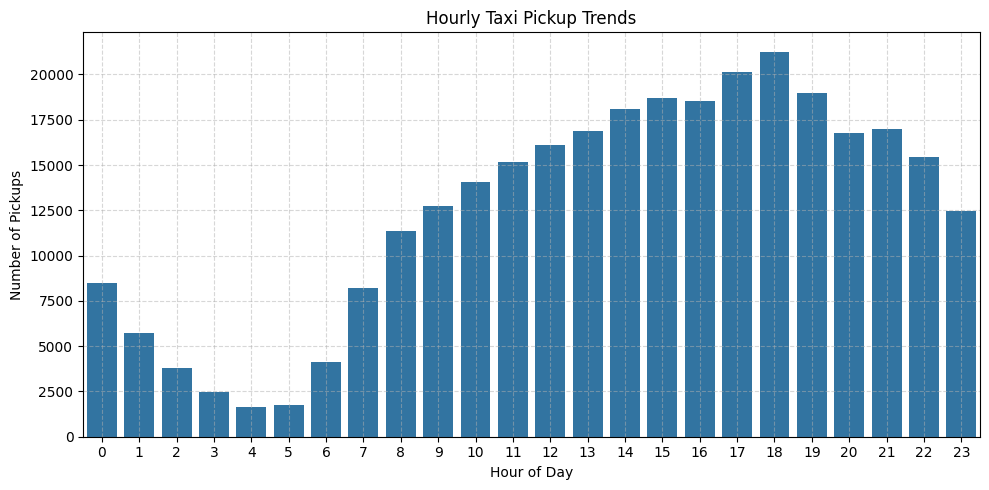

In [ ]:
# Find and show the hourly trends in taxi pickups
hourly_pickups = df.groupby('pickup_hour').size().reset_index(name='pickup_count')
hourly_pickups = hourly_pickups.sort_values(by='pickup_hour')

plt.figure(figsize=(10,5))
sns.barplot(data=hourly_pickups, x='pickup_hour', y='pickup_count')
plt.title('Hourly Taxi Pickup Trends')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pickups')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

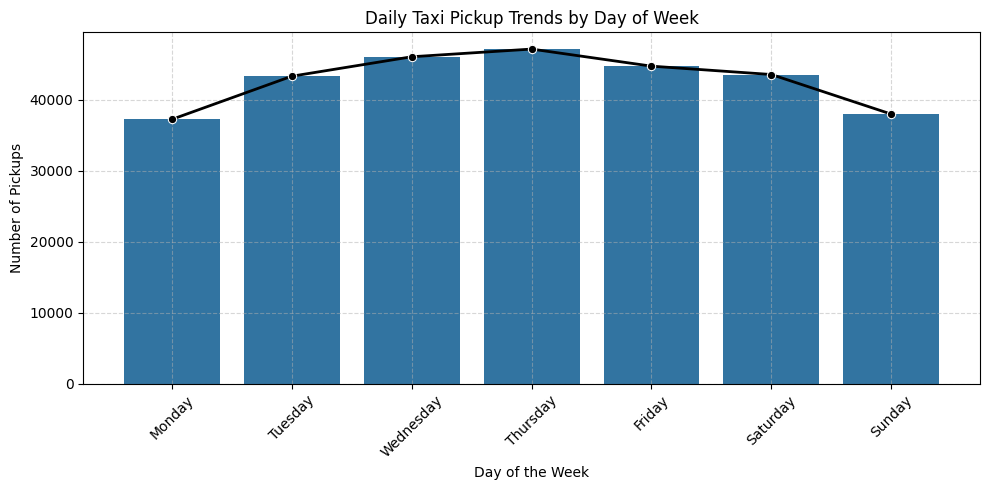

In [ ]:
# Find and show the daily trends in taxi pickups (days of the week)

df['pickup_day'] = df['tpep_pickup_datetime'].dt.day_name()
daily_pickups = df.groupby('pickup_day').size().reset_index(name='pickup_count')

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_pickups['pickup_day'] = pd.Categorical(daily_pickups['pickup_day'], categories=day_order, ordered=True)
daily_pickups = daily_pickups.sort_values('pickup_day')

plt.figure(figsize=(10,5))
sns.barplot(data=daily_pickups, x='pickup_day', y='pickup_count')
sns.lineplot(data=daily_pickups, x='pickup_day', y='pickup_count', color='black', marker='o', linewidth=2)

plt.title('Daily Taxi Pickup Trends by Day of Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Pickups')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

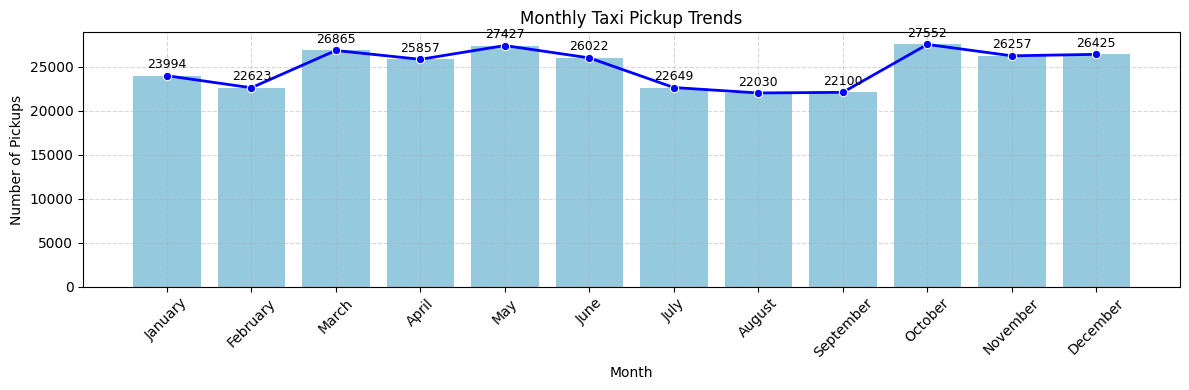

In [ ]:
# Show the monthly trends in pickups

df['pickup_month'] = df['tpep_pickup_datetime'].dt.month_name()
monthly_pickups = df.groupby('pickup_month').size().reset_index(name='pickup_count')

from calendar import month_name
month_order = list(month_name)[1:]
monthly_pickups['pickup_month'] = pd.Categorical(monthly_pickups['pickup_month'], categories=month_order, ordered=True)
monthly_pickups = monthly_pickups.sort_values('pickup_month')

plt.figure(figsize=(12, 4))
ax = sns.barplot(data=monthly_pickups, x='pickup_month', y='pickup_count', color='skyblue')
sns.lineplot(data=monthly_pickups, x='pickup_month', y='pickup_count', color='blue', marker='o', linewidth=2)

# Annotate bars accurately
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 500,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.title('Monthly Taxi Pickup Trends')
plt.xlabel('Month')
plt.ylabel('Number of Pickups')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [ ]:
# Analyse the above parameters
df[(df['total_amount']==0) & (df['PULocationID']==df['DOLocationID'])] #29 rows


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
23331          1  2023-01-31 14:18:45   2023-01-31 14:19:04              1.0   
32790          2  2023-05-29 07:52:56   2023-05-29 07:55:18              1.0   
43145          1  2023-11-29 07:52:06   2023-11-29 08:08:23              1.0   
56039          2  2023-07-01 11:54:34   2023-07-01 11:54:54              1.0   
89144          1  2023-06-28 15:08:48   2023-06-28 15:10:43              1.0   
96960          1  2023-07-11 09:12:42   2023-07-11 09:13:46              1.0   
106358         1  2023-06-20 20:59:38   2023-06-20 20:59:50              1.0   
112733         1  2023-01-08 13:06:14   2023-01-08 13:06:49              1.0   
124301         1  2023-04-26 13:56:46   2023-04-26 13:59:15              1.0   
127964         1  2023-10-25 11:56:00   2023-10-25 11:56:32              1.0   
130201         2  2023-07-25 12:54:18   2023-07-25 12:54:29              1.0   
138347         2  2023-10-15 10:46:22   2023-10-15 10:46:43              1.0   
154564         1  2023-08-07 13:54:06   2023-08-07 13:54:18              1.0   
161336         2  2023-03-28 22:35:55   2023-03-28 22:36:05              1.0   
165566         1  2023-01-25 11:59:35   2023-01-25 11:59:54              1.0   
176567         1  2023-08-24 03:00:49   2023-08-24 03:01:08              1.0   
179872         1  2023-02-09 13:09:29   2023-02-09 13:09:51              1.0   
188211         2  2023-01-27 13:28:50   2023-01-27 13:29:01              1.0   
194040         1  2023-02-19 19:09:58   2023-02-19 19:10:03              1.0   
194190         1  2023-04-02 11:41:34   2023-04-02 11:42:05              1.0   
208246         1  2023-04-15 15:49:30   2023-04-15 15:50:27              1.0   
210380         2  2023-06-03 15:41:16   2023-06-03 15:41:52              1.0   
217052         1  2023-05-12 12:20:10   2023-05-12 12:20:45              1.0   
239931         1  2023-04-14 18:37:00   2023-04-14 18:37:22              1.0   
242625         2  2023-10-09 13:08:37   2023-10-09 13:08:50              1.0   
245156         1  2023-01-14 23:22:45   2023-01-14 23:22:58              1.0   
276842         1  2023-12-07 20:56:37   2023-12-07 20:57:22              1.0   
278967         2  2023-07-25 10:30:45   2023-07-25 10:31:07              1.0   
297551         1  2023-12-12 09:05:46   2023-12-12 09:13:04              1.0   

        trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
23331             0.0         1.0                  N           138   
32790             0.0         1.0                  N           193   
43145             1.0         1.0                  N           230   
56039             0.0         1.0                  N           193   
89144             0.0         1.0                  N            66   
96960             0.0         1.0                  N           145   
106358            0.0         1.0                  N           164   
112733            0.0         1.0                  N           145   
124301            0.0         1.0                  N           130   
127964            0.0        99.0                  N            54   
130201            0.0         1.0                  N           264   
138347            0.0         1.0                  N           193   
154564            0.0         1.0                  N           140   
161336            0.0         1.0                  N           264   
165566            0.0         1.0                  N           132   
176567            0.0         1.0                  N           265   
179872            0.0         1.0                  N           145   
188211            0.0         1.0                  N           264   
194040            3.2         1.0                  N           265   
194190            0.0         1.0                  N           145   
208246            0.0         1.0                  Y            50   
210380            0.0         1.0                  N           193 

In [ ]:
df[(df['fare_amount']==0) & (df['total_amount']>0) & (df['trip_distance']>0)] #35 rows


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
9845           1  2023-08-24 22:51:53   2023-08-24 23:44:00              1.0   
12842          1  2023-06-19 14:29:09   2023-06-19 14:42:01              1.0   
17987          1  2023-05-14 03:32:17   2023-05-14 03:32:40              2.0   
36656          2  2023-02-02 08:12:32   2023-02-02 08:24:59              1.0   
36869          1  2023-12-23 02:29:14   2023-12-23 02:37:37              1.0   
41071          2  2023-03-03 20:02:23   2023-03-03 20:16:48              1.0   
43608          1  2023-05-12 12:48:53   2023-05-12 14:16:30              1.0   
47680          2  2023-05-09 17:05:56   2023-05-09 17:24:59              1.0   
48075          2  2023-11-11 18:50:47   2023-11-11 19:40:33              4.0   
59983          1  2023-03-25 04:10:08   2023-03-25 04:25:33              1.0   
68361          1  2023-03-16 18:20:45   2023-03-16 18:23:59              1.0   
70515          2  2023-03-13 11:40:22   2023-03-13 11:51:53              1.0   
72012          2  2023-01-25 11:10:37   2023-01-25 11:11:02              1.0   
77887          2  2023-08-25 12:18:23   2023-08-25 12:50:55              2.0   
85332          2  2023-01-15 03:38:12   2023-01-16 00:00:00              3.0   
90612          1  2023-07-15 00:58:59   2023-07-15 00:59:43              2.0   
90905          1  2023-09-09 03:35:34   2023-09-09 03:44:33              1.0   
92617          2  2023-07-23 07:26:25   2023-07-23 07:46:08              1.0   
98244          2  2023-11-08 20:33:27   2023-11-08 20:59:53              1.0   
98323          1  2023-11-11 10:41:38   2023-11-11 11:49:05              1.0   
133536         2  2023-02-08 08:44:49   2023-02-08 09:04:56              1.0   
165879         2  2023-11-27 14:24:21   2023-11-27 14:36:13              1.0   
166369         2  2023-03-05 02:40:08   2023-03-05 02:42:58              2.0   
194676         1  2023-05-25 18:58:04   2023-05-25 19:03:49              4.0   
207060         2  2023-02-20 00:13:13   2023-02-20 00:18:52              4.0   
210007         1  2023-10-12 16:42:29   2023-10-12 17:40:45              1.0   
220214         2  2023-11-14 20:42:13   2023-11-14 20:43:00              1.0   
223268         1  2023-12-24 02:28:52   2023-12-24 02:36:27              1.0   
238772         2  2023-12-18 07:49:40   2023-12-18 08:06:53              1.0   
243339         1  2023-04-27 11:59:34   2023-04-27 12:56:02              1.0   
264232         1  2023-05-28 13:54:23   2023-05-28 13:55:36              2.0   
266295         2  2023-08-19 00:33:06   2023-08-19 00:34:24              1.0   
285313         1  2023-05-05 12:45:50   2023-05-05 13:22:00              1.0   
290797         2  2023-05-29 04:20:24   2023-05-29 04:20:35              1.0   
292938         2  2023-10-30 06:20:16   2023-10-30 07:26:44              1.0   

        trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
9845            30.30         5.0                  N           132   
12842            2.80         5.0                  N           163   
17987            1.80         5.0                  N           230   
36656            2.12         1.0                  N           236   
36869            3.20         5.0                  N           246   
41071            1.68         1.0                  N           107   
43608           48.20         5.0                  N           124   
47680            8.35         1.0                  N           132   
48075           20.06         2.0                  N           132   
59983           11.70         5.0                  N           152   
68361            1.10         5.0                  N           132   
70515            3.49         1.0                  N           138   
72012            0.02         2.0                  N           170   
77887           11.71         1.0                  N            70   
85332            2.48         1.0                  N           246   
90612  

In [ ]:
df[(df['total_amount']==0) & (df['fare_amount']==0)] #49 rows


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
3301           1  2023-02-17 21:08:12   2023-02-17 21:54:18              1.0   
3573           1  2023-10-05 08:58:47   2023-10-05 08:59:12              1.0   
23331          1  2023-01-31 14:18:45   2023-01-31 14:19:04              1.0   
32790          2  2023-05-29 07:52:56   2023-05-29 07:55:18              1.0   
43145          1  2023-11-29 07:52:06   2023-11-29 08:08:23              1.0   
52290          1  2023-07-25 12:35:41   2023-07-25 12:44:47              1.0   
56039          2  2023-07-01 11:54:34   2023-07-01 11:54:54              1.0   
66459          1  2023-10-22 21:13:40   2023-10-22 21:21:16              1.0   
82602          1  2023-03-06 16:51:00   2023-03-06 17:00:23              1.0   
89144          1  2023-06-28 15:08:48   2023-06-28 15:10:43              1.0   
96960          1  2023-07-11 09:12:42   2023-07-11 09:13:46              1.0   
97273          1  2023-08-07 03:37:22   2023-08-07 05:52:47              1.0   
106358         1  2023-06-20 20:59:38   2023-06-20 20:59:50              1.0   
112733         1  2023-01-08 13:06:14   2023-01-08 13:06:49              1.0   
116163         1  2023-10-31 15:42:05   2023-10-31 15:46:18              1.0   
124301         1  2023-04-26 13:56:46   2023-04-26 13:59:15              1.0   
125842         2  2023-02-01 16:53:34   2023-02-01 16:54:13              1.0   
127062         1  2023-10-02 14:05:53   2023-10-02 14:06:12              1.0   
127964         1  2023-10-25 11:56:00   2023-10-25 11:56:32              1.0   
130201         2  2023-07-25 12:54:18   2023-07-25 12:54:29              1.0   
138347         2  2023-10-15 10:46:22   2023-10-15 10:46:43              1.0   
144084         1  2023-11-08 15:29:15   2023-11-08 15:29:47              1.0   
154564         1  2023-08-07 13:54:06   2023-08-07 13:54:18              1.0   
161336         2  2023-03-28 22:35:55   2023-03-28 22:36:05              1.0   
164173         1  2023-05-27 13:54:05   2023-05-27 14:17:29              1.0   
165566         1  2023-01-25 11:59:35   2023-01-25 11:59:54              1.0   
176567         1  2023-08-24 03:00:49   2023-08-24 03:01:08              1.0   
179872         1  2023-02-09 13:09:29   2023-02-09 13:09:51              1.0   
188211         2  2023-01-27 13:28:50   2023-01-27 13:29:01              1.0   
194040         1  2023-02-19 19:09:58   2023-02-19 19:10:03              1.0   
194190         1  2023-04-02 11:41:34   2023-04-02 11:42:05              1.0   
208246         1  2023-04-15 15:49:30   2023-04-15 15:50:27              1.0   
210380         2  2023-06-03 15:41:16   2023-06-03 15:41:52              1.0   
217052         1  2023-05-12 12:20:10   2023-05-12 12:20:45              1.0   
239931         1  2023-04-14 18:37:00   2023-04-14 18:37:22              1.0   
242625         2  2023-10-09 13:08:37   2023-10-09 13:08:50              1.0   
245156         1  2023-01-14 23:22:45   2023-01-14 23:22:58              1.0   
273270         1  2023-11-08 04:38:05   2023-11-08 04:41:18              1.0   
276842         1  2023-12-07 20:56:37   2023-12-07 20:57:22              1.0   
278848         1  2023-08-02 14:28:40   2023-08-02 14:48:47              1.0   
278967         2  2023-07-25 10:30:45   2023-07-25 10:31:07              1.0   
282158         1  2023-11-06 16:01:22   2023-11-06 16:05:12              1.0   
297551         1  2023-12-12 09:05:46   2023-12-12 09:13:04              1.0   

        trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
3301             16.1         1.0                  Y           209   
3573              0.0         1.0                  N           238   
23331             0.0         1.0                  N           138   
32790             0.0         1.0                  N           193   
43145             1.0         1.0                  N           230   
52290             4.5         5.0                  N           138 

In [ ]:
df[(df['trip_distance']==0) & (df['total_amount']==0)] #38 rows



VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
3573           1  2023-10-05 08:58:47   2023-10-05 08:59:12              1.0   
23331          1  2023-01-31 14:18:45   2023-01-31 14:19:04              1.0   
32790          2  2023-05-29 07:52:56   2023-05-29 07:55:18              1.0   
56039          2  2023-07-01 11:54:34   2023-07-01 11:54:54              1.0   
89144          1  2023-06-28 15:08:48   2023-06-28 15:10:43              1.0   
96960          1  2023-07-11 09:12:42   2023-07-11 09:13:46              1.0   
106358         1  2023-06-20 20:59:38   2023-06-20 20:59:50              1.0   
112733         1  2023-01-08 13:06:14   2023-01-08 13:06:49              1.0   
124301         1  2023-04-26 13:56:46   2023-04-26 13:59:15              1.0   
125842         2  2023-02-01 16:53:34   2023-02-01 16:54:13              1.0   
127062         1  2023-10-02 14:05:53   2023-10-02 14:06:12              1.0   
127964         1  2023-10-25 11:56:00   2023-10-25 11:56:32              1.0   
130201         2  2023-07-25 12:54:18   2023-07-25 12:54:29              1.0   
138347         2  2023-10-15 10:46:22   2023-10-15 10:46:43              1.0   
144084         1  2023-11-08 15:29:15   2023-11-08 15:29:47              1.0   
154564         1  2023-08-07 13:54:06   2023-08-07 13:54:18              1.0   
161336         2  2023-03-28 22:35:55   2023-03-28 22:36:05              1.0   
164173         1  2023-05-27 13:54:05   2023-05-27 14:17:29              1.0   
165566         1  2023-01-25 11:59:35   2023-01-25 11:59:54              1.0   
176567         1  2023-08-24 03:00:49   2023-08-24 03:01:08              1.0   
179872         1  2023-02-09 13:09:29   2023-02-09 13:09:51              1.0   
188211         2  2023-01-27 13:28:50   2023-01-27 13:29:01              1.0   
194190         1  2023-04-02 11:41:34   2023-04-02 11:42:05              1.0   
208246         1  2023-04-15 15:49:30   2023-04-15 15:50:27              1.0   
210380         2  2023-06-03 15:41:16   2023-06-03 15:41:52              1.0   
217052         1  2023-05-12 12:20:10   2023-05-12 12:20:45              1.0   
239931         1  2023-04-14 18:37:00   2023-04-14 18:37:22              1.0   
242625         2  2023-10-09 13:08:37   2023-10-09 13:08:50              1.0   
245156         1  2023-01-14 23:22:45   2023-01-14 23:22:58              1.0   
273270         1  2023-11-08 04:38:05   2023-11-08 04:41:18              1.0   
276842         1  2023-12-07 20:56:37   2023-12-07 20:57:22              1.0   
278967         2  2023-07-25 10:30:45   2023-07-25 10:31:07              1.0   

        trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
3573              0.0         1.0                  N           238   
23331             0.0         1.0                  N           138   
32790             0.0         1.0                  N           193   
56039             0.0         1.0                  N           193   
89144             0.0         1.0                  N            66   
96960             0.0         1.0                  N           145   
106358            0.0         1.0                  N           164   
112733            0.0         1.0                  N           145   
124301            0.0         1.0                  N           130   
125842            0.0         1.0                  N           193   
127062            0.0         1.0                  N            70   
127964            0.0        99.0                  N            54   
130201            0.0         1.0                  N           264   
138347            0.0         1.0                  N           193   
144084            0.0         1.0                  N           164   
154564            0.0         1.0                  N           140   
161336            0.0         1.0                  N           264   
164173            0.0         1.0                  N            70   
165566            0.0         1.0    

In [ ]:
df[(df['trip_distance']==0) & (df['PULocationID']==df['DOLocationID']) & (df['total_amount']>0)] #2450 rows

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
33             2  2023-12-29 14:11:38   2023-12-29 14:11:46              1.0   
42             1  2023-04-28 11:43:27   2023-04-28 11:52:03              1.0   
413            2  2023-07-11 20:59:25   2023-07-11 20:59:30              2.0   
500            1  2023-12-20 15:41:50   2023-12-20 15:42:11              1.0   
531            1  2023-01-19 01:14:06   2023-01-19 01:14:58              1.0   
...          ...                  ...                   ...              ...   
298948         2  2023-06-18 02:12:39   2023-06-18 02:13:28              1.0   
299065         2  2023-04-02 23:15:24   2023-04-02 23:15:33              1.0   
299150         2  2023-12-20 19:46:39   2023-12-20 19:46:49              2.0   
299827         2  2023-05-11 21:01:02   2023-05-11 21:01:04              1.0   
299952         2  2023-09-11 12:09:21   2023-09-11 12:09:39              6.0   

        trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
33                0.0         1.0                  N           193   
42                0.0         1.0                  N           145   
413               0.0         2.0                  N           264   
500               0.0         2.0                  N           193   
531               0.0         5.0                  N           162   
...               ...         ...                ...           ...   
298948            0.0         3.0                  N           187   
299065            0.0         1.0                  N           132   
299150            0.0         2.0                  N           263   
299827            0.0         5.0                  N           100   
299952            0.0         1.0                  N           233   

        DOLocationID  payment_type  ...  tolls_amount  improvement_surcharge  \
33               193             3  ...           0.0                    1.0   
42               145             2  ...           0.0                    1.0   
413              264             2  ...           0.0                    1.0   
500              193             2  ...           0.0                    1.0   
531              162             1  ...           0.0                    1.0   
...              ...           ...  ...           ...                    ...   
298948           187             1  ...           0.0                    1.0   
299065           132             2  ...           0.0                    1.0   
299150           263             2  ...           0.0                    1.0   
299827           100             1  ...           0.0                    1.0   
299952           233             4  ...           0.0                    1.0   

        total_amount  congestion_surcharge  pickup_date  pickup_hour  \
33              4.50                   0.0   2023-12-29           14   
42             10.10                   0.0   2023-04-28           11   
413            71.50                   0.0   2023-07-11           20   
500            71.50                   0.0   2023-12-20           15   
531            19.00                   0.0   2023-01-19            1   
...              ...                   ...          ...          ...   
298948         25.00                   0.0   2023-06-18            2   
299065          6.75                   0.0   2023-04-02           23   
299150         79.00                   2.5   2023-12-20           19   
299827        106.56                   2.5   2023-05-11           21   
299952          7.00                   2.5   2023-09-11           12   

        AirportFee  trip_duration_in_minutes pickup_day  pickup_month  
33            0.00                  0.133333     Friday      December  
42            0.00                  8.600000     Friday         April  
413           0.00                  0.083333    Tuesday          July  
500           0.00                  0.350000  Wednesday      December  
531           0.00  

In [ ]:
df[(df['trip_distance']==0) & (df['PULocationID']!=df['DOLocationID']) & (df['total_amount']>0)] #3431 rows

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
57             2  2023-03-01 16:11:26   2023-03-01 16:11:28              1.0   
75             1  2023-10-03 22:16:18   2023-10-03 22:23:32              1.0   
106            1  2023-09-11 16:05:25   2023-09-11 16:34:08              1.0   
129            1  2023-10-29 18:02:04   2023-10-29 18:19:12              1.0   
205            1  2023-12-27 16:45:41   2023-12-27 16:55:28              1.0   
...          ...                  ...                   ...              ...   
299521         1  2023-07-26 22:32:15   2023-07-26 22:46:02              1.0   
299528         1  2023-11-05 20:38:27   2023-11-05 20:48:31              1.0   
299634         1  2023-11-12 14:51:26   2023-11-12 15:03:11              1.0   
299734         1  2023-12-15 10:15:34   2023-12-15 10:24:52              1.0   
299817         1  2023-10-18 05:38:46   2023-10-18 05:48:38              1.0   

        trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
57                0.0         5.0                  N           161   
75                0.0         1.0                  N           249   
106               0.0         1.0                  N           236   
129               0.0         1.0                  N            75   
205               0.0         1.0                  N            50   
...               ...         ...                ...           ...   
299521            0.0         1.0                  N           249   
299528            0.0         1.0                  N           164   
299634            0.0         1.0                  N            79   
299734            0.0         1.0                  N           164   
299817            0.0         1.0                  N           164   

        DOLocationID  payment_type  ...  tolls_amount  improvement_surcharge  \
57               264             1  ...           0.0                    1.0   
75               144             0  ...           0.0                    1.0   
106               50             0  ...           0.0                    1.0   
129              143             0  ...           0.0                    1.0   
205              158             0  ...           0.0                    1.0   
...              ...           ...  ...           ...                    ...   
299521           233             0  ...           0.0                    1.0   
299528           114             0  ...           0.0                    1.0   
299634           164             0  ...           0.0                    1.0   
299734            68             0  ...           0.0                    1.0   
299817           140             0  ...           0.0                    1.0   

        total_amount  congestion_surcharge  pickup_date  pickup_hour  \
57             20.80                   0.0   2023-03-01           16   
75             11.52                   2.5   2023-10-03           22   
106            34.40                   2.5   2023-09-11           16   
129            22.55                   2.5   2023-10-29           18   
205            22.49                   2.5   2023-12-27           16   
...              ...                   ...          ...          ...   
299521         22.52                   2.5   2023-07-26           22   
299528         15.72                   2.5   2023-11-05           20   
299634         18.84                   2.5   2023-11-12           14   
299734         17.60                   2.5   2023-12-15           10   
299817         16.58                   2.5   2023-10-18            5   

        AirportFee  trip_duration_in_minutes pickup_day  pickup_month  
57             0.0                  0.033333  Wednesday         March  
75             0.0                  7.233333    Tuesday       October  
106            0.0                 28.716667     Monday     September  
129            0.0                 17.133333     Sunday       October  
205            0.0  

In [ ]:
df[(df['PULocationID']==df['DOLocationID']) & (df['total_amount']>0) & (df['trip_distance']!=0)] #short trips

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
5              1  2023-04-26 23:46:30   2023-04-26 23:48:04              1.0   
29             2  2023-12-06 20:56:02   2023-12-06 20:58:57              1.0   
31             2  2023-09-28 16:59:17   2023-09-28 17:14:24              2.0   
55             2  2023-11-13 15:41:01   2023-11-13 15:45:51              1.0   
63             2  2023-05-19 16:39:28   2023-05-19 16:45:09              1.0   
...          ...                  ...                   ...              ...   
299939         2  2023-08-21 13:35:05   2023-08-21 13:38:24              1.0   
299949         2  2023-09-08 19:29:52   2023-09-08 19:47:00              1.0   
299960         2  2023-03-15 12:17:31   2023-03-15 12:26:22              1.0   
299966         2  2023-06-21 13:43:10   2023-06-21 13:47:13              1.0   
299989         2  2023-08-20 03:23:16   2023-08-20 03:25:38              1.0   

        trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
5                0.60         1.0                  N           141   
29               0.70         1.0                  N           236   
31               0.68         1.0                  N           161   
55               0.68         1.0                  N           236   
63               0.38         1.0                  N           170   
...               ...         ...                ...           ...   
299939           0.60         1.0                  N            48   
299949           1.26         1.0                  N           230   
299960           0.65         1.0                  N           162   
299966           0.58         1.0                  N           239   
299989           0.37         1.0                  N            48   

        DOLocationID  payment_type  ...  tolls_amount  improvement_surcharge  \
5                141             2  ...           0.0                    1.0   
29               236             1  ...           0.0                    1.0   
31               161             1  ...           0.0                    1.0   
55               236             2  ...           0.0                    1.0   
63               170             1  ...           0.0                    1.0   
...              ...           ...  ...           ...                    ...   
299939            48             1  ...           0.0                    1.0   
299949           230             2  ...           0.0                    1.0   
299960           162             1  ...           0.0                    1.0   
299966           239             1  ...           0.0                    1.0   
299989            48             1  ...           0.0                    1.0   

        total_amount  congestion_surcharge  pickup_date  pickup_hour  \
5              10.10                   2.5   2023-04-26           23   
29             12.42                   2.5   2023-12-06           20   
31             24.00                   2.5   2023-09-28           16   
55             10.50                   2.5   2023-11-13           15   
63             14.95                   2.5   2023-05-19           16   
...              ...                   ...          ...          ...   
299939         11.76                   2.5   2023-08-21           13   
299949         21.40                   2.5   2023-09-08           19   
299960         17.29                   2.5   2023-03-15           12   
299966          9.80                   2.5   2023-06-21           13   
299989         11.28                   2.5   2023-08-20            3   

        AirportFee  trip_duration_in_minutes pickup_day  pickup_month  
5              0.0                  1.566667  Wednesday         April  
29             0.0                  2.916667  Wednesday      December  
31             0.0                 15.116667   Thursday     September  
55             0.0                  4.833333     Monday      November  
63             0.0  

Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [ ]:
# Create a df with non zero entries for the selected parameters.
df =df[~((df['total_amount']==0) & (df['PULocationID']==df['DOLocationID']))]


In [ ]:
df = df[~((df['fare_amount']==0) & (df['total_amount']>0) & (df['trip_distance']>0))] #these case are different seems incorrect because the trip distance is there but total amount is really less because the fare amount i not there and only tolls amount and improvement surcharge is added


In [ ]:
df = df[~((df['total_amount']==0) & (df['fare_amount']==0))]

In [ ]:
df = df[~((df['trip_distance']==0) & (df['total_amount']==0))] #drop rows where trip distance and total amount is zero


In [ ]:
df = df[~((df['trip_distance']==0) & (df['PULocationID']==df['DOLocationID']) & (df['total_amount']>0))] # less than 2% data where even pickup and drop location is same so the amount would not be valid


In [ ]:
df = df[~((df['trip_distance']==0) & (df['PULocationID']!=df['DOLocationID']) & (df['total_amount']>0))] #around 2% data only so dropping it

**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

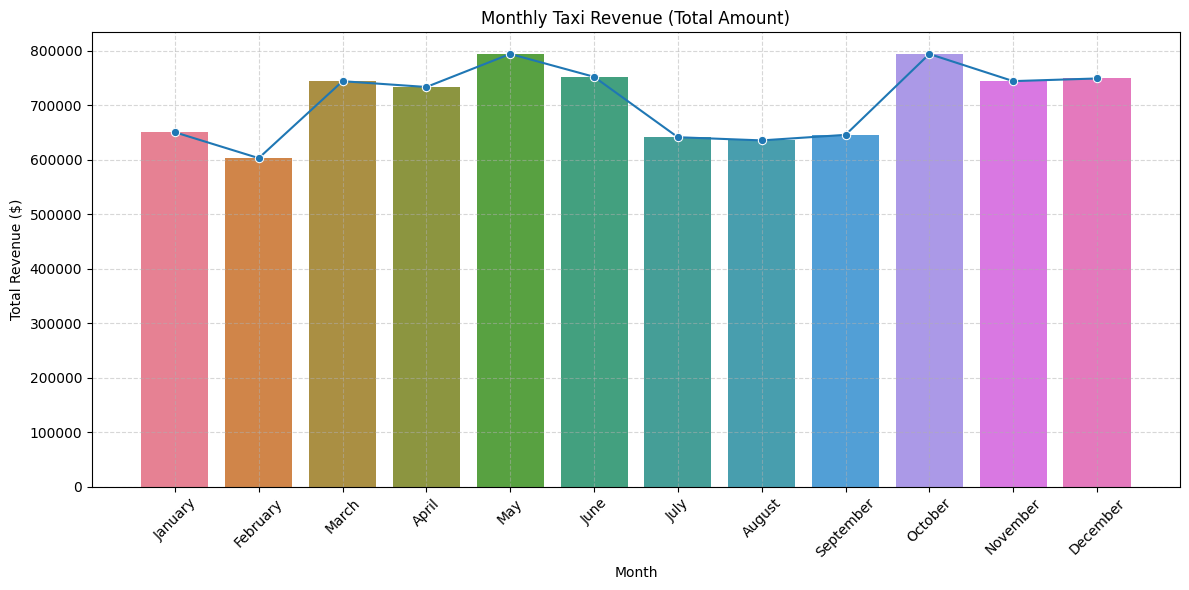

In [ ]:
# Group data by month and analyse monthly revenue
import calendar

month_order = list(calendar.month_name)[1:]
df['pickup_month'] = pd.Categorical(df['pickup_month'], categories=month_order, ordered=True)
monthly_revenue = df.groupby('pickup_month', observed=True)['total_amount'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=monthly_revenue, x='pickup_month', y='total_amount',hue='pickup_month')

sns.lineplot(data=monthly_revenue, x='pickup_month', y='total_amount', marker='o')

plt.title('Monthly Taxi Revenue (Total Amount)')
plt.xlabel('Month')
plt.ylabel('Total Revenue ($)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

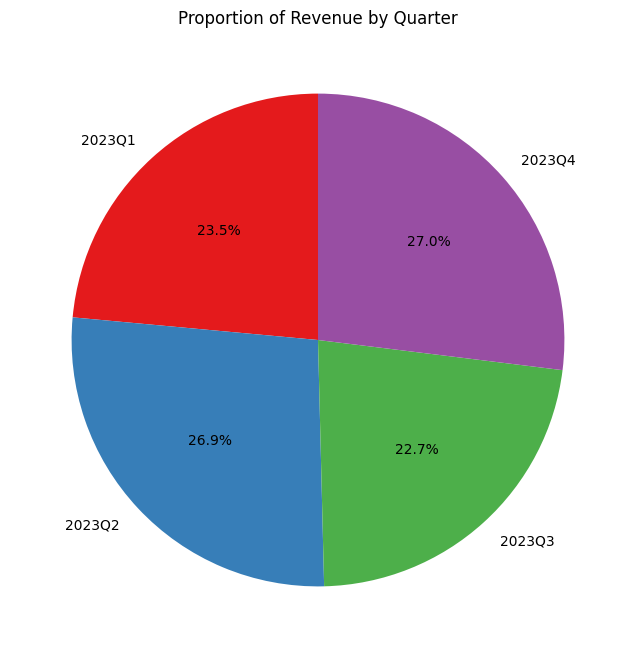

In [ ]:
# Calculate proportion of each quarter
df['quarter'] = df['tpep_pickup_datetime'].dt.to_period('Q')
quarterly_revenue = df.groupby('quarter')['total_amount'].sum().reset_index()
plt.figure(figsize=(8, 8))
plt.pie(quarterly_revenue['total_amount'], labels=quarterly_revenue['quarter'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set1", len(quarterly_revenue)))
plt.title('Proportion of Revenue by Quarter')
plt.show()


**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

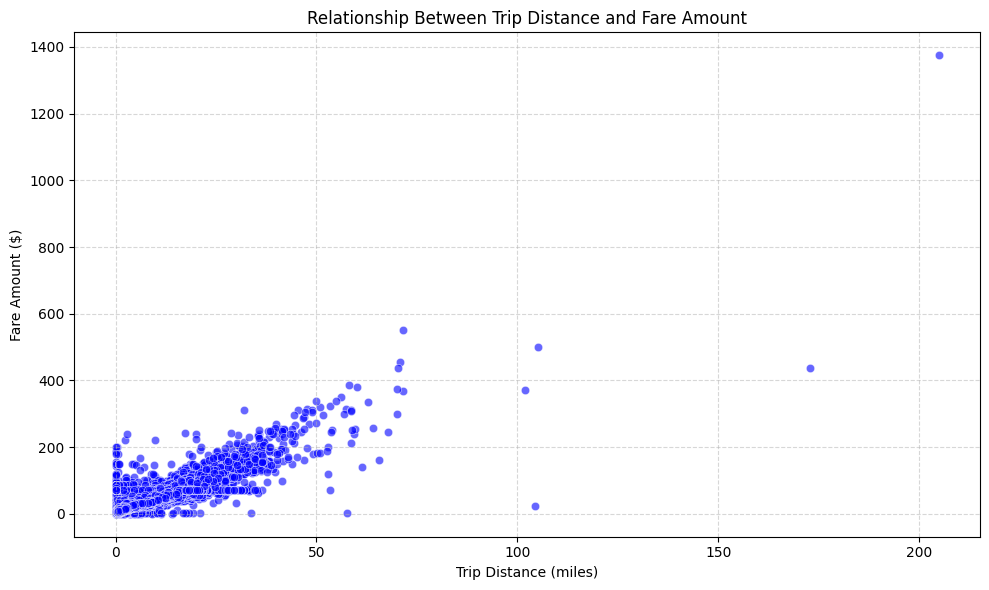

The correlation coefficient between trip_distance and fare_amount is: 0.9423


In [ ]:
# Show how trip fare is affected by distance
plt.figure(figsize=(10, 6))

# Scatter plot
sns.scatterplot(data=df, x='trip_distance', y='fare_amount', color='blue', alpha=0.6)

# Add title and labels
plt.title('Relationship Between Trip Distance and Fare Amount')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

correlation = df['trip_distance'].corr(df['fare_amount'])
print(f"The correlation coefficient between trip_distance and fare_amount is: {correlation:.4f}")


**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

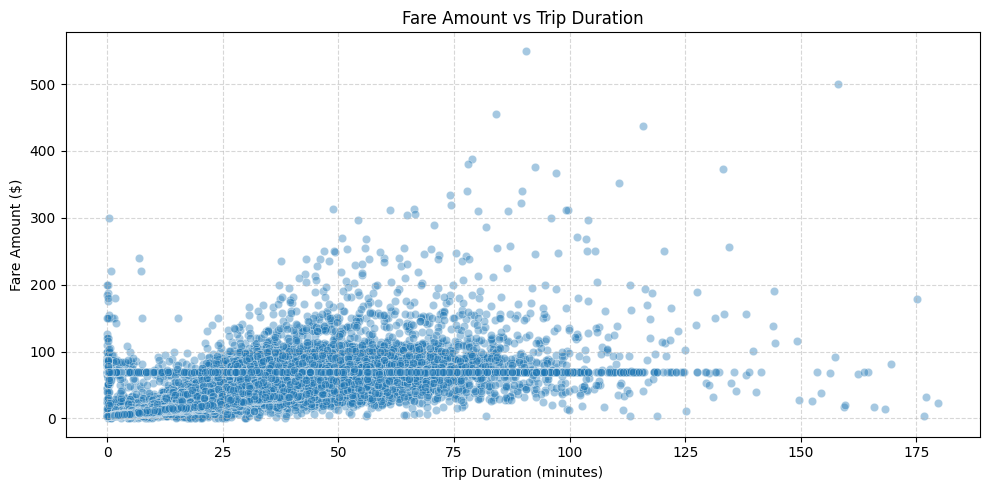

The correlation between trip duration and fare amount: 0.8425


In [ ]:
# Show relationship between fare and trip duration

df_filtered = df[(df['trip_duration_in_minutes'] <= 180)]
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_filtered, x='trip_duration_in_minutes', y='fare_amount', alpha=0.4)

plt.title('Fare Amount vs Trip Duration')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Fare Amount ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


correlation = df_filtered['trip_duration_in_minutes'].corr(df_filtered['fare_amount'])
print(f"The correlation between trip duration and fare amount: {correlation:.4f}")


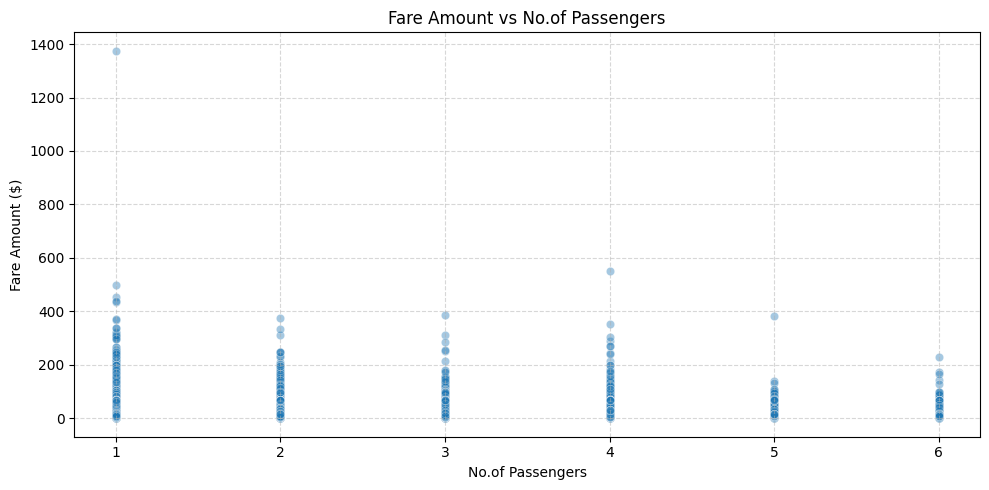

The correlation between number of passengers and fare amount: 0.0415


In [ ]:
# Show relationship between fare and number of passengers

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='passenger_count', y='fare_amount', alpha=0.4)

plt.title('Fare Amount vs No.of Passengers')
plt.xlabel('No.of Passengers')
plt.ylabel('Fare Amount ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


correlation = df['passenger_count'].corr(df['fare_amount'])
print(f"The correlation between number of passengers and fare amount: {correlation:.4f}")

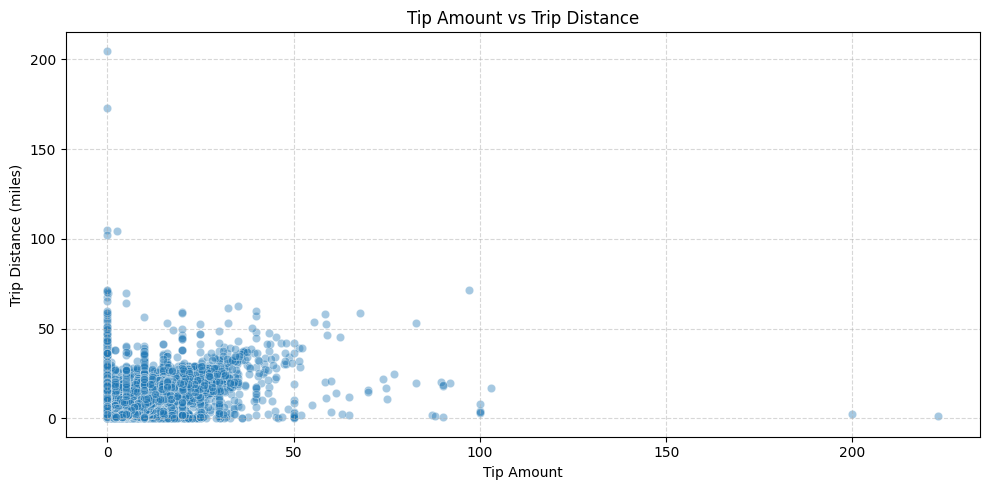

The correlation between number of tip amount and trip distance: 0.5819


In [ ]:
# Show relationship between tip and trip distance

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='tip_amount', y='trip_distance', alpha=0.4)

plt.title('Tip Amount vs Trip Distance')
plt.xlabel('Tip Amount')
plt.ylabel('Trip Distance (miles)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


correlation = df['tip_amount'].corr(df['trip_distance'])
print(f"The correlation between number of tip amount and trip distance: {correlation:.4f}")

**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

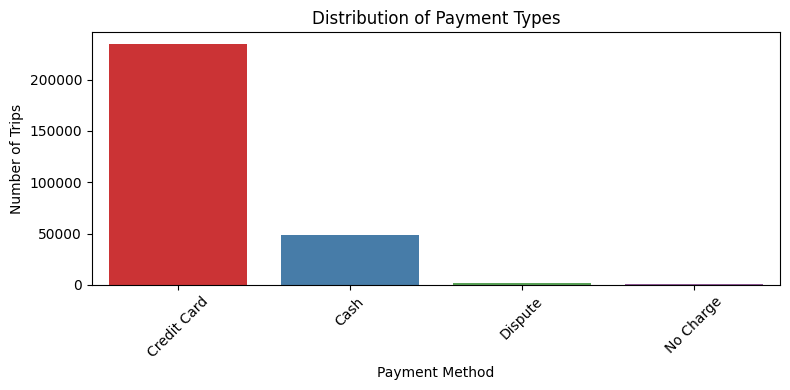

In [ ]:
# Analyse the distribution of different payment types (payment_type).

payment_map = {
    1: 'Credit Card',
    2: 'Cash',
    3: 'No Charge',
    4: 'Dispute'
}

df['payment_type_label'] = df['payment_type'].map(payment_map)

payment_counts = df['payment_type_label'].value_counts().reset_index()
payment_counts.columns = ['Payment Type', 'Count']


plt.figure(figsize=(8, 4))

bar = sns.barplot(
    data=payment_counts,
    x='Payment Type',
    y='Count',
    hue='Payment Type',
    palette='Set1',
    legend=False
)

plt.title('Distribution of Payment Types')
plt.xticks(rotation=45)
plt.ylabel('Number of Trips')
plt.xlabel('Payment Method')
plt.tight_layout()
plt.show()

- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [ ]:
!pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [ ]:
import geopandas as gpd


# Read the shapefile using geopandas
path = '/content/drive/MyDrive/taxi_zones/taxi_zones.shp'
zones =gpd.read_file(path) # read the .shp file using gpd
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

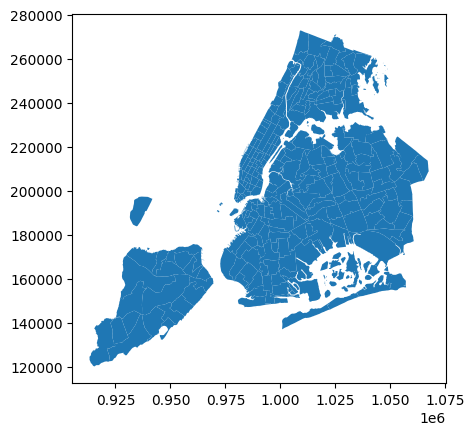

In [ ]:
print(zones.info())
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [ ]:
# Merge zones and trip records using locationID and PULocationID

zones= zones.rename(columns={'LocationID': 'PULocationID'})
merged_df = df.merge(zones, on='PULocationID', how='left')

merged_df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-06-25 22:34:24   2023-06-25 22:59:09              2.0   
1         2  2023-02-09 09:35:03   2023-02-09 10:01:31              1.0   
2         1  2023-05-07 20:22:38   2023-05-07 20:32:32              2.0   
3         1  2023-07-10 12:08:14   2023-07-10 12:17:15              1.0   
4         2  2023-11-08 15:38:53   2023-11-08 15:56:51              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           5.53         1.0                  N           158            40   
1           9.84         1.0                  N           234           138   
2           1.00         1.0                  N            48           161   
3           1.80         1.0                  N           239            75   
4           2.61         1.0                  N           186           113   

   payment_type  ...  pickup_day  pickup_month  quarter  payment_type_label  \
0             1  ...      Sunday          June   2023Q2         Credit Card   
1             1  ...    Thursday      February   2023Q1         Credit Card   
2             1  ...      Sunday           May   2023Q2         Credit Card   
3             1  ...      Monday          July   2023Q3         Credit Card   
4             1  ...   Wednesday      November   2023Q4         Credit Card   

   OBJECTID  Shape_Leng  Shape_Area                           zone    borough  \
0     158.0    0.054810    0.000186  Meatpacking/West Village West  Manhattan   
1     234.0    0.036072    0.000073                       Union Sq  Manhattan   
2      48.0    0.043747    0.000094                   Clinton East  Manhattan   
3     239.0    0.063626    0.000205          Upper West Side South  Manhattan   
4     186.0    0.024696    0.000037   Penn Station/Madison Sq West  Manhattan   

                                            geometry  
0  POLYGON ((982091.02 209596.704, 982318.344 209...  
1  POLYGON ((987029.847 207022.299, 987048.27 206...  
2  POLYGON ((986694.313 214463.846, 986568.184 21...  
3  POLYGON ((991168.979 226252.992, 991955.565 22...  
4  POLYGON ((986752.603 210853.699, 986627.863 21...  

[5 rows x 32 columns]

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [ ]:
# Group data by location and calculate the number of trips
trips_counts = df.groupby('PULocationID').size().reset_index(name='trip_count')

trips_counts.head()


PULocationID  trip_count
0             1          11
1             3           6
2             4         369
3             5           1
4             6           6

**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [ ]:
# Merge trip counts back to the zones GeoDataFrame

zones_with_counts = zones.merge(trips_counts, on='PULocationID', how='left')
zones_with_counts.sort_values(by='trip_count', ascending=False).head(10)

zones_with_counts.sort_values(by='trip_count', ascending=True).head(10)

OBJECTID  Shape_Leng  Shape_Area                       zone  \
4           5    0.092146    0.000498              Arden Heights   
43         44    0.235689    0.001945     Charleston/Tottenville   
45         46    0.134475    0.000926                City Island   
72         73    0.085302    0.000292              East Flushing   
100       101    0.101710    0.000452                  Glen Oaks   
205       206    0.212757    0.000944  Saint George/New Brighton   
203       204    0.101912    0.000641          Rossville/Woodrow   
200       201    0.130404    0.000619              Rockaway Park   
213       214    0.135300    0.000812   South Beach/Dongan Hills   
256       257    0.058669    0.000139            Windsor Terrace   

     PULocationID        borough  \
4               5  Staten Island   
43             44  Staten Island   
45             46          Bronx   
72             73         Queens   
100           101         Queens   
205           206  Staten Island   
203           204  Staten Island   
200           201         Queens   
213           214  Staten Island   
256           257       Brooklyn   

                                              geometry  trip_count  
4    POLYGON ((935843.31 144283.336, 936046.565 144...         1.0  
43   POLYGON ((925284.273 142075.259, 924921.951 14...         1.0  
45   MULTIPOLYGON (((1043853.395 252845.891, 104386...         1.0  
72   POLYGON ((1040865.308 212673.974, 1040649.312 ...         1.0  
100  POLYGON ((1066997.47 212947.337, 1067047.985 2...         1.0  
205  POLYGON ((961436.305 175473.03, 961460.942 175...         1.0  
203  POLYGON ((927766.539 141772.465, 927864.475 14...         1.0  
200  POLYGON ((1034661.735 153320.591, 1034718.155 ...         1.0  
213  POLYGON ((960669.201 156319.132, 960902.551 15...         1.0  
256  POLYGON ((989842.548 179997.856, 989842.643 17...         1.0

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

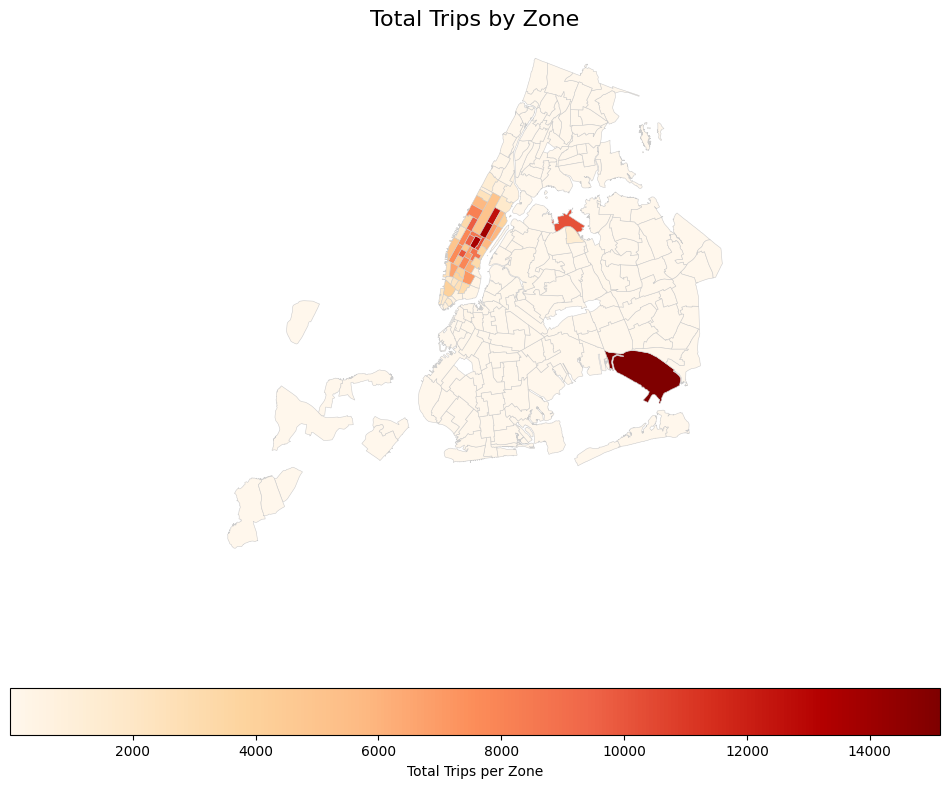

In [ ]:
# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize = (12, 10))

# Plot the map and display it
zones_with_counts.plot(
    column='trip_count',
    ax=ax,
    legend=True,
    cmap='OrRd',
    edgecolor='0.8',
    linewidth=0.4,
    legend_kwds={
        'label': "Total Trips per Zone",
        'orientation': "horizontal"
    }
)

plt.title('Total Trips by Zone', fontsize=16)
plt.axis('off')
plt.show()


In [ ]:
# can you try displaying the zones DF sorted by the number of trips?

zones_sorted = zones_with_counts.sort_values(by='trip_count', ascending=False)
zones_sorted.head()

OBJECTID  Shape_Leng  Shape_Area                   zone  PULocationID  \
131       132    0.245479    0.002038            JFK Airport           132   
236       237    0.042213    0.000096  Upper East Side South           237   
160       161    0.035804    0.000072         Midtown Center           161   
235       236    0.044252    0.000103  Upper East Side North           236   
161       162    0.035270    0.000048           Midtown East           162   

       borough                                           geometry  trip_count  
131     Queens  MULTIPOLYGON (((1032791.001 181085.006, 103283...     15144.0  
236  Manhattan  POLYGON ((993633.442 216961.016, 993507.232 21...     13854.0  
160  Manhattan  POLYGON ((991081.026 214453.698, 990952.644 21...     13625.0  
235  Manhattan  POLYGON ((995940.048 221122.92, 995812.322 220...     12570.0  
161  Manhattan  POLYGON ((992224.354 214415.293, 992096.999 21...     10292.0

Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [ ]:
# Find routes which have the slowest speeds at different times of the day
df['trip_duration_hours'] = df['trip_duration_in_minutes']/60
route_stats = df.groupby(['PULocationID', 'DOLocationID', 'pickup_hour']).agg({
    'trip_distance': 'mean',
    'trip_duration_hours': 'mean'
}).reset_index()
route_stats['avg_speed_mph'] = route_stats['trip_distance'] / route_stats['trip_duration_hours']
slow_routes = route_stats.sort_values(by='avg_speed_mph').head(10)

slow_routes = slow_routes.merge(zones[['PULocationID', 'zone']], left_on='PULocationID', right_on='PULocationID', how='left')
slow_routes = slow_routes.rename(columns={'zone': 'pickup_zone'}).drop('PULocationID', axis=1)

# Merge to get dropoff zone name
slow_routes = slow_routes.merge(zones[['PULocationID', 'zone']], left_on='DOLocationID', right_on='PULocationID', how='left')
slow_routes = slow_routes.rename(columns={'zone': 'dropoff_zone'}).drop('PULocationID', axis=1)

# Reorder or select only relevant columns
slow_routes = slow_routes[['pickup_zone', 'dropoff_zone', 'pickup_hour', 'trip_distance', 'trip_duration_hours', 'avg_speed_mph']]

slow_routes.dropna(subset=['pickup_zone', 'dropoff_zone'], inplace=True)

slow_routes

pickup_zone                       dropoff_zone  pickup_hour  \
0  Two Bridges/Seward Park        Downtown Brooklyn/MetroTech           13   
2                Sunnyside                          Sunnyside           15   
3    Upper East Side South            Queensbridge/Ravenswood           19   
4  Greenwich Village North  University Heights/Morris Heights           22   
5          Randalls Island                    Randalls Island           16   
6          Lower East Side            Two Bridges/Seward Park           12   
7             Clinton West                       Central Park            8   
8            Midtown North       Penn Station/Madison Sq West            4   
9             Midtown East                       Midtown East            4   

   trip_distance  trip_duration_hours  avg_speed_mph  
0          0.490            92.040556       0.005324  
2          0.010             0.777778       0.012857  
3          0.010             0.643889       0.015531  
4          0.280             5.820556       0.048105  
5          0.010             0.204444       0.048913  
6          1.210            23.461667       0.051573  
7          1.420            23.855556       0.059525  
8          1.630            23.684444       0.068822  
9          0.975            11.895000       0.081967

How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

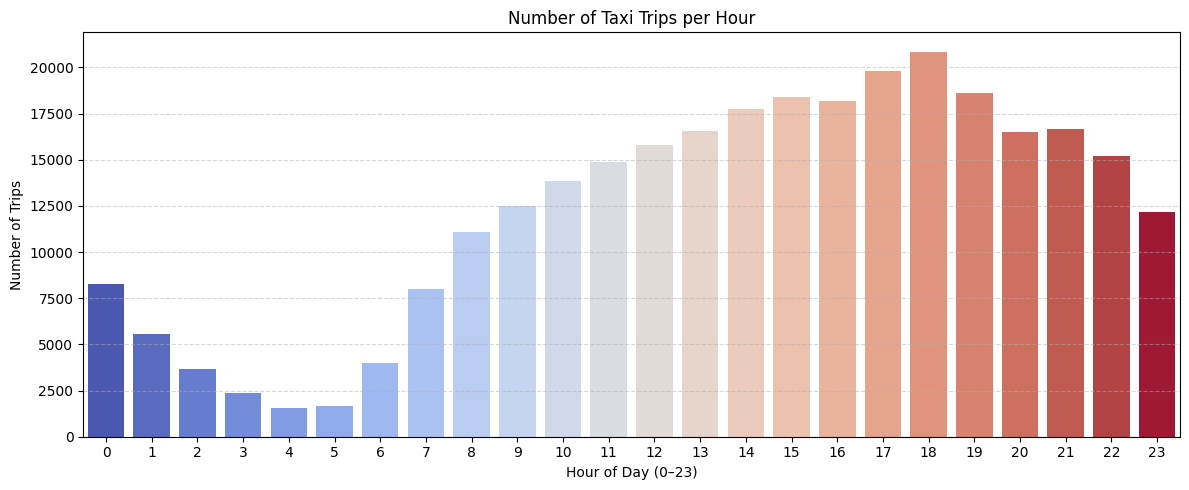

Busiest Hour: 18:00 with 20856 trips


In [ ]:
# Visualise the number of trips per hour and find the busiest hour
trips_per_hour = df['pickup_hour'].value_counts().sort_index()
hourly_df = pd.DataFrame({
    'hour': trips_per_hour.index,
    'trip_count': trips_per_hour.values
})

plt.figure(figsize=(12, 5))
sns.barplot(data=hourly_df, x='hour', y='trip_count', hue='hour', palette='coolwarm', dodge=False, legend=False)

plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Number of Trips')
plt.title('Number of Taxi Trips per Hour')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

busiest_hour = trips_per_hour.idxmax()
busiest_count = trips_per_hour.max()
print(f"Busiest Hour: {busiest_hour}:00 with {busiest_count} trips")


Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [ ]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers
sample_fraction = 0.10
scaling_factor = 1 / sample_fraction
trips_per_hour_scaled = trips_per_hour * scaling_factor
busiest_hours = trips_per_hour_scaled.sort_values(ascending=False).head(5)
busiest_hours


pickup_hour
18    208560.0
17    197950.0
19    186220.0
15    183780.0
16    181910.0
Name: count, dtype: float64

**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

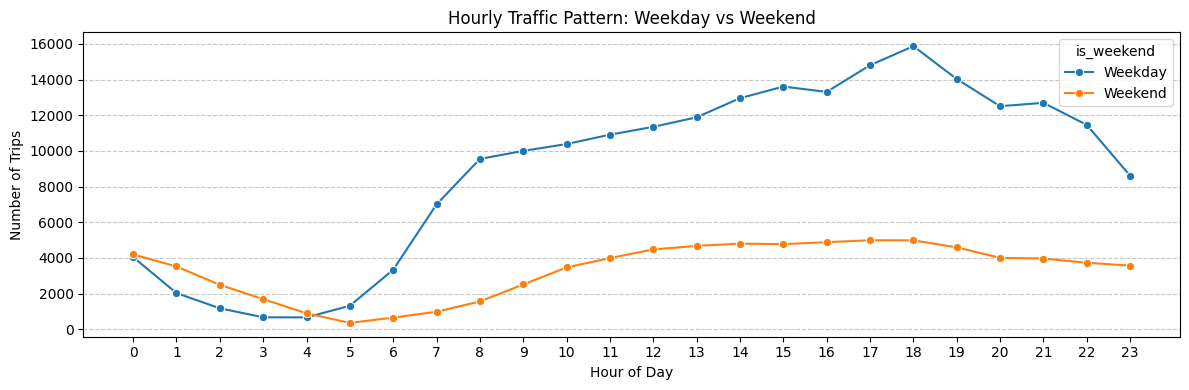

In [ ]:
# Compare traffic trends for the week days and weekends

df['day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
hourly_comparison = df.groupby(['pickup_hour', 'is_weekend']).size().reset_index(name='trip_count')

plt.figure(figsize=(12, 4))
sns.lineplot(data=hourly_comparison, x='pickup_hour', y='trip_count', hue='is_weekend', marker='o')

plt.title('Hourly Traffic Pattern: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

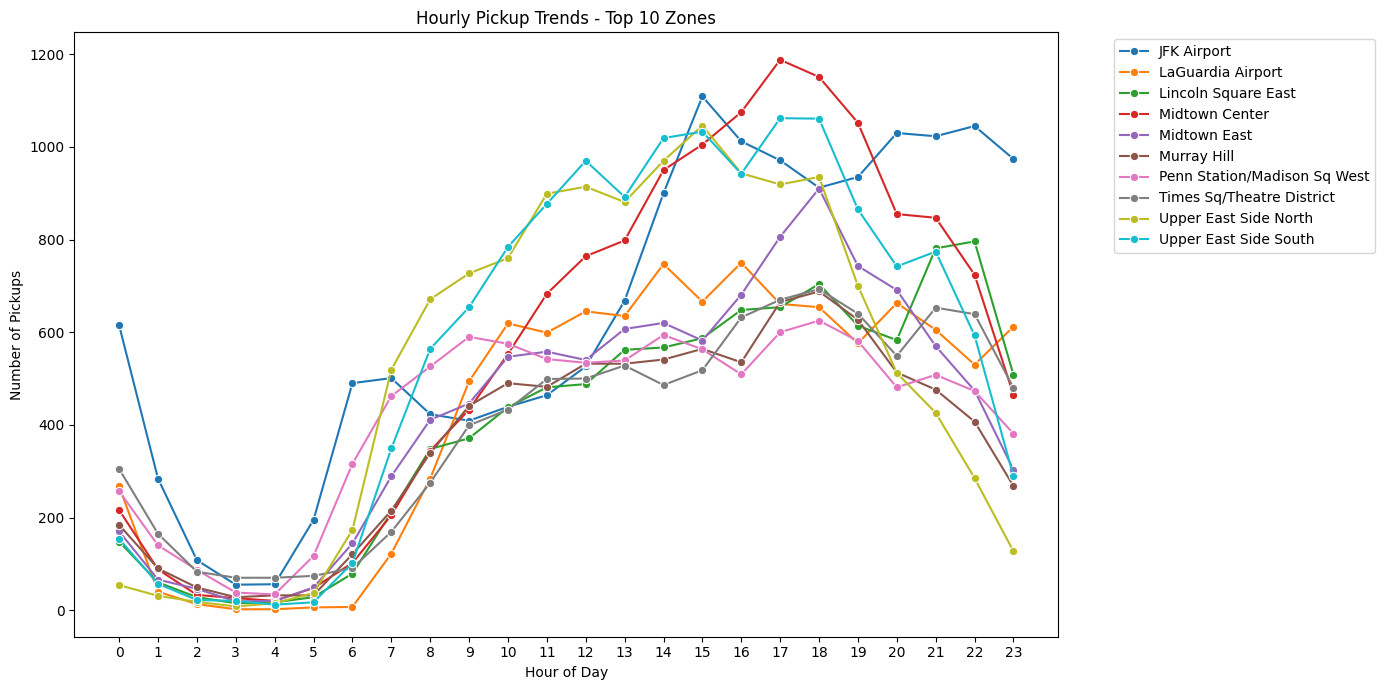

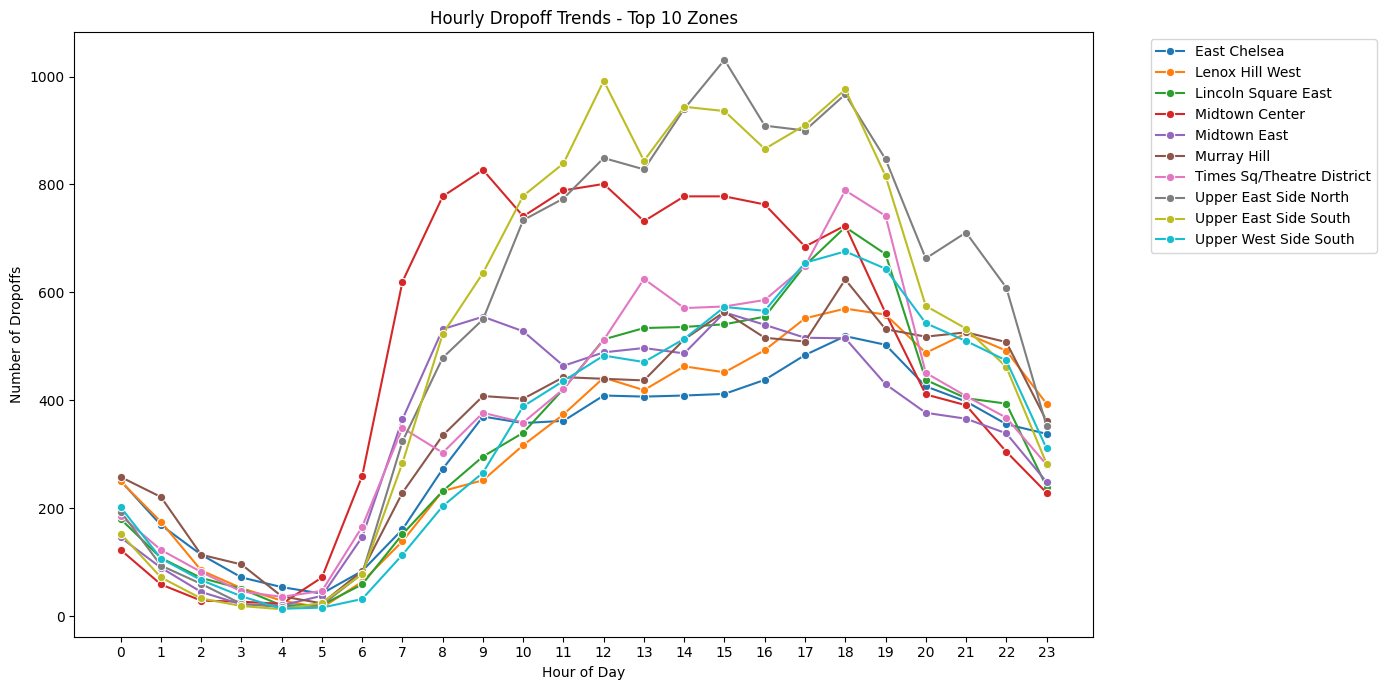

In [ ]:
# Find top 10 pickup and dropoff zones

zones_df = gpd.read_file(path)
df['dropoff_hour'] = df['tpep_dropoff_datetime'].dt.hour

pickup_counts = df.groupby(['PULocationID', 'pickup_hour']).size().reset_index(name='pickup_trips')
total_pickups = df.groupby('PULocationID').size().reset_index(name='total_pickups')
top10_pickup_zones = total_pickups.sort_values(by='total_pickups', ascending=False).head(10)['PULocationID']
pickup_trends = pickup_counts[pickup_counts['PULocationID'].isin(top10_pickup_zones)]

dropoff_counts = df.groupby(['DOLocationID', 'dropoff_hour']).size().reset_index(name='dropoff_trips')
total_dropoffs = df.groupby('DOLocationID').size().reset_index(name='total_dropoffs')
top10_dropoff_zones = total_dropoffs.sort_values(by='total_dropoffs', ascending=False).head(10)['DOLocationID']
dropoff_trends = dropoff_counts[dropoff_counts['DOLocationID'].isin(top10_dropoff_zones)]

pickup_trends = pickup_trends.merge(zones_df[['LocationID', 'zone']], left_on='PULocationID', right_on='LocationID')
dropoff_trends = dropoff_trends.merge(zones_df[['LocationID', 'zone']], left_on='DOLocationID', right_on='LocationID')

plt.figure(figsize=(14, 7))
sns.lineplot(data=pickup_trends, x='pickup_hour', y='pickup_trips', hue='zone', marker='o')
plt.title('Hourly Pickup Trends - Top 10 Zones')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pickups')
plt.xticks(range(24))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
sns.lineplot(data=dropoff_trends, x='dropoff_hour', y='dropoff_trips', hue='zone', marker='o')
plt.title('Hourly Dropoff Trends - Top 10 Zones')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Dropoffs')
plt.xticks(range(24))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [ ]:
# Find the top 10 and bottom 10 pickup/dropoff ratios

pickup_counts = pickup_counts.rename(columns={'PULocationID': 'LocationID', 'pickup_count': 'pickups'})
dropoff_counts = dropoff_counts.rename(columns={'DOLocationID': 'LocationID', 'dropoff_count': 'dropoffs'})

zone_ratios = pd.merge(pickup_counts, dropoff_counts, on='LocationID', how='outer')
zone_ratios.fillna(0, inplace=True)

zone_ratios['pickup_drop_ratio'] = zone_ratios['pickup_trips'] / zone_ratios['dropoff_trips'].replace(0, np.nan)

zone_ratios = zone_ratios.merge(zones_df[['LocationID', 'zone']], on='LocationID', how='left')

top_ratios = zone_ratios.sort_values(by='pickup_drop_ratio', ascending=False).head(10)
bottom_ratios = zone_ratios.sort_values(by='pickup_drop_ratio', ascending=True).head(10)

print("Top 10 Zones with Highest Pickup/Dropoff Ratio:")
print(top_ratios[['zone', 'pickup_drop_ratio']])

print("\nBottom 10 Zones with Lowest Pickup/Dropoff Ratio:")
print(bottom_ratios[['zone', 'pickup_drop_ratio']])


Top 10 Zones with Highest Pickup/Dropoff Ratio:
                    zone  pickup_drop_ratio
34317  LaGuardia Airport         250.000000
34319  LaGuardia Airport         250.000000
34271  LaGuardia Airport         249.000000
34269  LaGuardia Airport         249.000000
34293  LaGuardia Airport         222.000000
34295  LaGuardia Airport         222.000000
32469        JFK Airport         221.800000
34415  LaGuardia Airport         221.000000
34413  LaGuardia Airport         221.000000
34341  LaGuardia Airport         220.333333

Bottom 10 Zones with Lowest Pickup/Dropoff Ratio:
                  zone  pickup_drop_ratio
48397       Pelham Bay                0.0
48395       Pelham Bay                0.0
48396       Pelham Bay                0.0
48402  Pelham Bay Park                0.0
48401  Pelham Bay Park                0.0
48400       Pelham Bay                0.0
48399       Pelham Bay                0.0
48398       Pelham Bay                0.0
48403  Pelham Bay Park                0

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [ ]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones

night_pickups = df[(df['pickup_hour'] >= 23) | (df['pickup_hour'] <= 5)]
night_dropoffs = df[(df['dropoff_hour'] >= 23) | (df['dropoff_hour'] <= 5)]

night_pickup_counts = night_pickups.groupby('PULocationID').size().reset_index(name='night_pickups')
night_dropoff_counts = night_dropoffs.groupby('DOLocationID').size().reset_index(name='night_dropoffs')

night_pickup_counts.rename(columns={'PULocationID': 'LocationID'}, inplace=True)
night_dropoff_counts.rename(columns={'DOLocationID': 'LocationID'}, inplace=True)

night_traffic = pd.merge(night_pickup_counts, night_dropoff_counts, on='LocationID', how='outer').fillna(0)


night_traffic = night_traffic.merge(zones_df[['LocationID', 'zone']], on='LocationID', how='left')

night_traffic['total_night_traffic'] = night_traffic['night_pickups'] + night_traffic['night_dropoffs']
top_night_zones = night_traffic.sort_values(by='total_night_traffic', ascending=False).head(10)

top_night_zones


LocationID  night_pickups  night_dropoffs                       zone  \
73           79         2632.0          1480.0               East Village   
228         249         2025.0           837.0               West Village   
43           48         1687.0          1143.0               Clinton East   
119         132         2287.0           238.0                JFK Airport   
135         148         1588.0           765.0            Lower East Side   
210         230         1247.0           801.0  Times Sq/Theatre District   
62           68          981.0          1040.0               East Chelsea   
96          107          932.0          1005.0                   Gramercy   
102         114         1493.0           441.0    Greenwich Village South   
157         170          683.0          1112.0                Murray Hill   

     total_night_traffic  
73                4112.0  
228               2862.0  
43                2830.0  
119               2525.0  
135               2353.0  
210               2048.0  
62                2021.0  
96                1937.0  
102               1934.0  
157               1795.0

In [ ]:
night_traffic.sort_values(by='total_night_traffic', ascending=True).head(10)

LocationID  night_pickups  night_dropoffs                       zone  \
3             5            0.0             1.0              Arden Heights   
20           23            1.0             0.0    Bloomfield/Emerson Hill   
27           30            0.0             1.0              Broad Channel   
41           46            0.0             1.0                City Island   
53           57            0.0             1.0                        NaN   
89           96            0.0             1.0  Forest Park/Highland Park   
99          111            0.0             1.0        Green-Wood Cemetery   
224         245            0.0             1.0              West Brighton   
201         221            0.0             1.0                  Stapleton   
93          101            0.0             2.0                  Glen Oaks   

     total_night_traffic  
3                    1.0  
20                   1.0  
27                   1.0  
41                   1.0  
53                   1.0  
89                   1.0  
99                   1.0  
224                  1.0  
201                  1.0  
93                   2.0

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

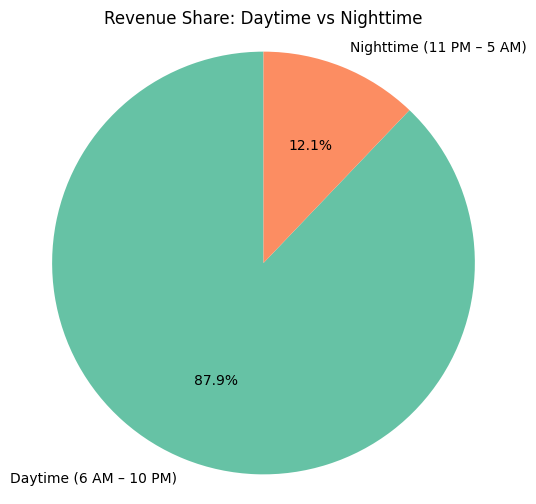

In [ ]:
# Filter for night hours (11 PM to 5 AM)

day_pickups = df[(df['pickup_hour'] >= 6) & (df['pickup_hour'] <= 22)]

night_revenue = night_pickups['total_amount'].sum()
day_revenue = day_pickups['total_amount'].sum()
total_revenue = night_revenue + day_revenue

night_share = (night_revenue / total_revenue) * 100
day_share = (day_revenue / total_revenue) * 100

labels = ['Daytime (6 AM – 10 PM)', 'Nighttime (11 PM – 5 AM)']
shares = [day_share, night_share]

plt.figure(figsize=(6,6))
plt.pie(shares, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
plt.title('Revenue Share: Daytime vs Nighttime')
plt.axis('equal')
plt.show()

##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [ ]:
# Analyse the fare per mile per passenger for different passenger counts
# Filter out invalid data


#invalid datas are cleaned up already


valid_df = df.copy()
valid_df['fare_per_mile'] = valid_df['fare_amount'] / valid_df['trip_distance']
grouped = valid_df.groupby('passenger_count')['fare_per_mile'].mean().reset_index()
grouped['Avg fare_per_mile_per_passenger'] = grouped['fare_per_mile'] / grouped['passenger_count']

grouped

passenger_count  fare_per_mile  Avg fare_per_mile_per_passenger
0              1.0      10.858782                        10.858782
1              2.0      12.116418                         6.058209
2              3.0      10.180754                         3.393585
3              4.0      19.020791                         4.755198
4              5.0       9.760717                         1.952143
5              6.0       8.255743                         1.375957

**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

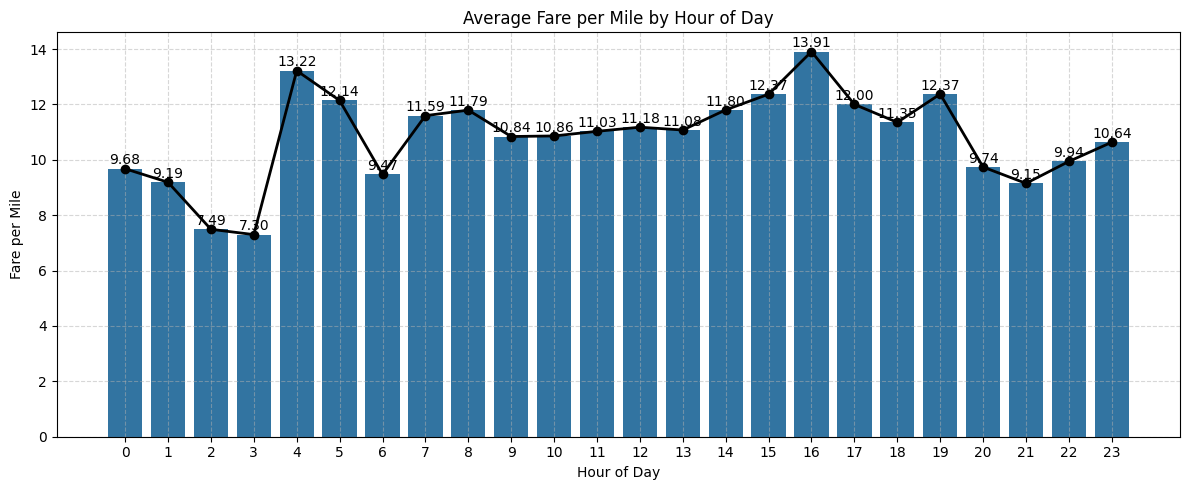

In [ ]:
# Compare the average fare per mile for different days and for different times of the day

avg_fare_by_day = valid_df.groupby('pickup_day')['fare_per_mile'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(8,4))
sns.barplot(x=avg_fare_by_day.index, y=avg_fare_by_day.values)
plt.plot(avg_fare_by_day.index, avg_fare_by_day.values, color='black', marker='o', linewidth=2, label='Line Trend')

for i, value in enumerate(avg_fare_by_day.values):
    plt.text(i, value + 0.05, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

plt.title('Average Fare per Mile by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Fare per Mile')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


avg_fare_by_hour = valid_df.groupby('pickup_hour')['fare_per_mile'].mean()

plt.figure(figsize=(12,5))
sns.barplot(x=avg_fare_by_hour.index, y=avg_fare_by_hour.values)
plt.plot(avg_fare_by_hour.index, avg_fare_by_hour.values, color='black', marker='o', linewidth=2, label='Line Trend')

for i, value in enumerate(avg_fare_by_hour.values):
    plt.text(i, value + 0.05, f'{value:.2f}', ha='center', va='bottom', fontsize=10)


plt.title('Average Fare per Mile by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fare per Mile')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

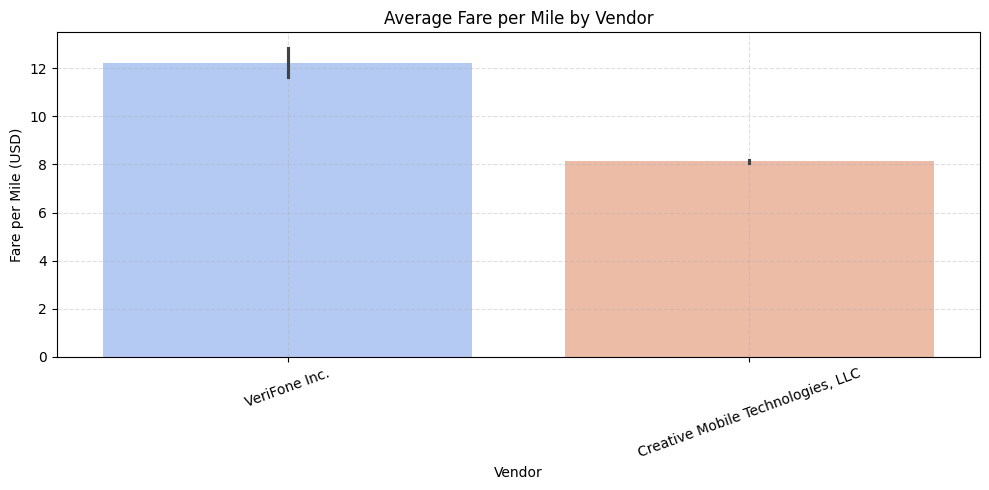

In [ ]:
# Compare fare per mile for different vendors

vendor_map = {
    1: 'Creative Mobile Technologies, LLC',
    2: 'VeriFone Inc.'
}

valid_df['Vendor Name'] = valid_df['VendorID'].map(vendor_map)

plt.figure(figsize=(10,5))
sns.barplot(data=valid_df, x='Vendor Name', y='fare_per_mile',hue='Vendor Name', palette='coolwarm')


plt.title('Average Fare per Mile by Vendor')
plt.xlabel('Vendor')
plt.ylabel('Fare per Mile (USD)')
plt.xticks(rotation=20)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


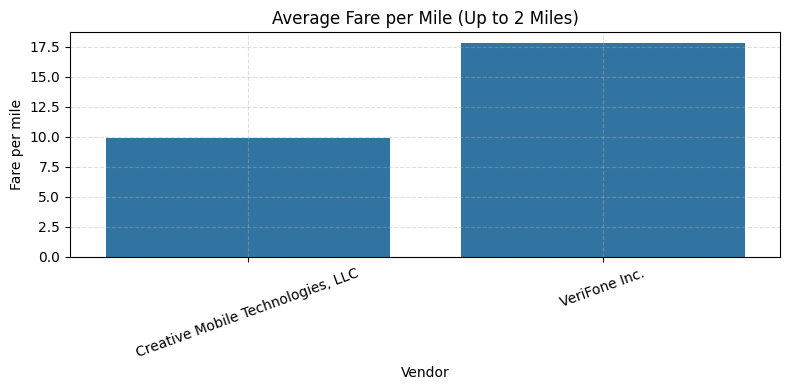

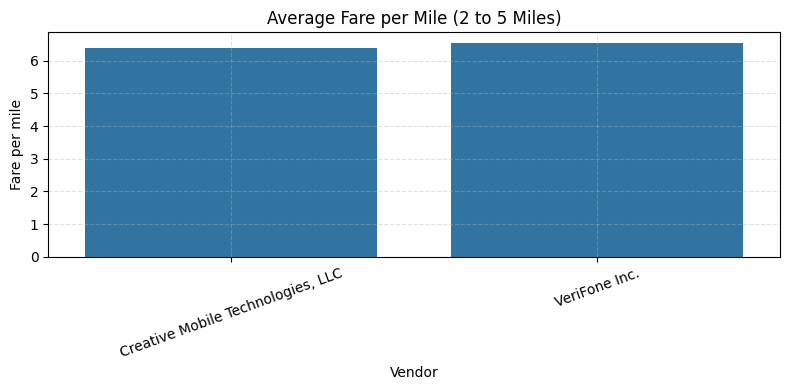

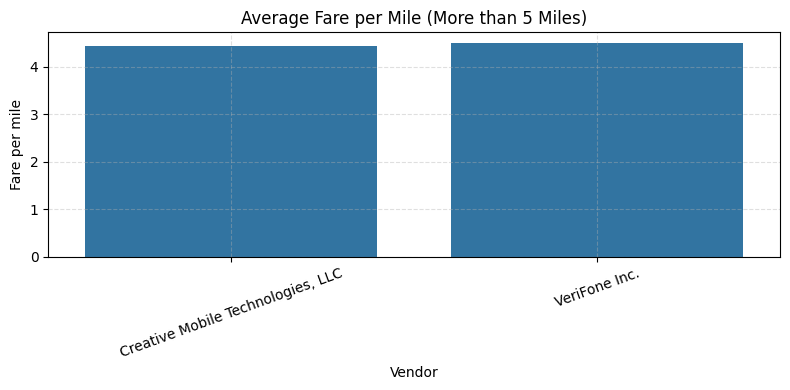

In [ ]:
# Defining distance tiers
data_2_miles = valid_df[valid_df['trip_distance'] <= 2]
data_2_to_5_miles = valid_df[(valid_df['trip_distance'] > 2) & (valid_df['trip_distance'] <= 5)]
data_5_miles_plus = valid_df[valid_df['trip_distance'] > 5]

fare_per_mile_2_miles = data_2_miles.groupby('Vendor Name')['fare_per_mile'].mean().reset_index()
fare_per_mile_2_to_5_miles = data_2_to_5_miles.groupby('Vendor Name')['fare_per_mile'].mean().reset_index()
fare_per_mile_5_miles_plus = data_5_miles_plus.groupby('Vendor Name')['fare_per_mile'].mean().reset_index()


def plot_fare_comparison(df, title):
    plt.figure(figsize=(8,4))
    sns.barplot(data=df, x='Vendor Name', y='fare_per_mile')


    plt.title(title)
    plt.xlabel('Vendor')
    plt.ylabel('Fare per mile')
    plt.xticks(rotation=20)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


plot_fare_comparison(fare_per_mile_2_miles, 'Average Fare per Mile (Up to 2 Miles)')
plot_fare_comparison(fare_per_mile_2_to_5_miles, 'Average Fare per Mile (2 to 5 Miles)')
plot_fare_comparison(fare_per_mile_5_miles_plus, 'Average Fare per Mile (More than 5 Miles)')

##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

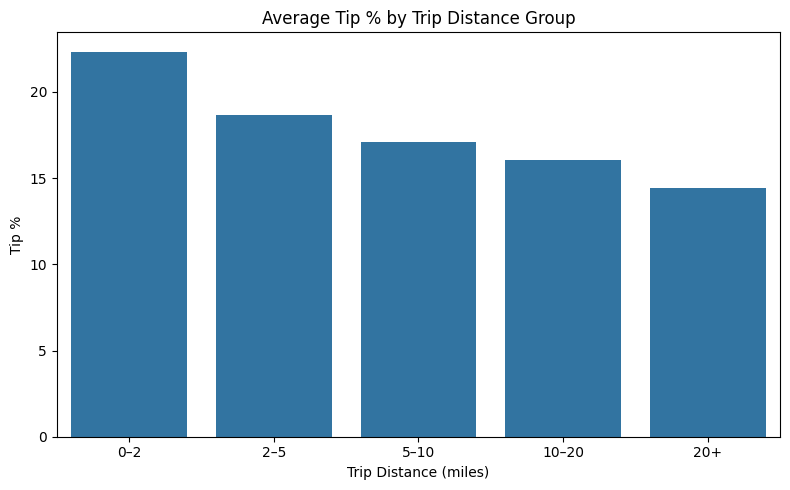

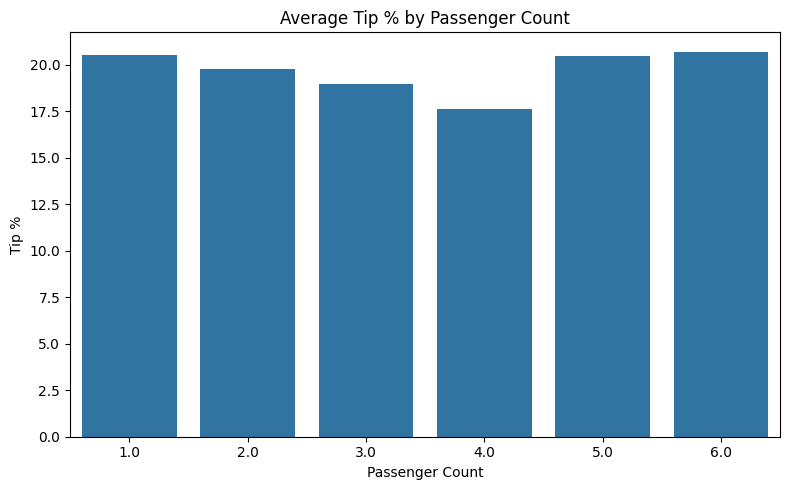

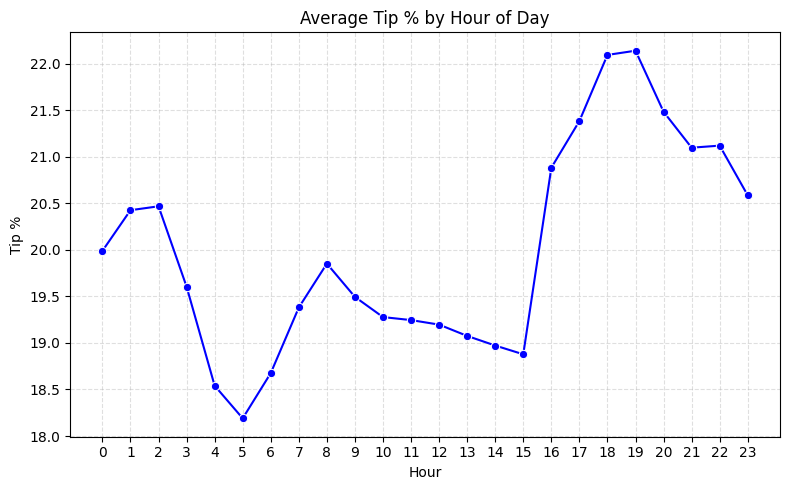

In [ ]:
#  Analyze tip percentages based on distances, passenger counts and pickup times
valid_df['tip_percent'] = (valid_df['tip_amount'] / valid_df['fare_amount']) * 100

bins = [0, 2, 5, 10, 20, valid_df['trip_distance'].max()]
labels = ['0–2', '2–5', '5–10', '10–20', '20+']
valid_df['distance_group'] = pd.cut(valid_df['trip_distance'], bins=bins, labels=labels)

tip_by_distance = valid_df.groupby('distance_group', observed=True)['tip_percent'].mean().reset_index()
tip_by_passenger = valid_df.groupby('passenger_count')['tip_percent'].mean().reset_index()

valid_df['pickup_hour'] = pd.to_datetime(valid_df['tpep_pickup_datetime']).dt.hour
tip_by_hour = valid_df.groupby('pickup_hour')['tip_percent'].mean().reset_index()

# Tip vs Trip distance
plt.figure(figsize=(8,5))
sns.barplot(data=tip_by_distance, x='distance_group', y='tip_percent')
plt.title('Average Tip % by Trip Distance Group')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Tip %')
plt.tight_layout()
plt.show()

# Tip vs Passenger Count
plt.figure(figsize=(8,5))
sns.barplot(data=tip_by_passenger, x='passenger_count', y='tip_percent')
plt.title('Average Tip % by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Tip %')
plt.tight_layout()
plt.show()

# Tip vs Hour of Day
plt.figure(figsize=(8,5))
sns.lineplot(data=tip_by_hour, x='pickup_hour', y='tip_percent', marker='o', color='blue')
plt.title('Average Tip % by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Tip %')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

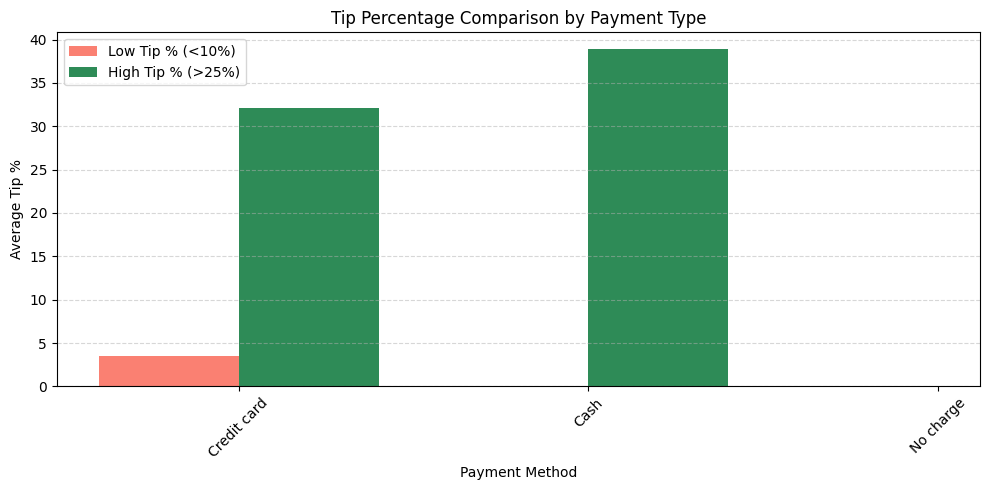

In [ ]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%

low_tip = valid_df[valid_df['tip_percent'] < 10]
high_tip = valid_df[valid_df['tip_percent'] > 25]

low_tip_by_payment = low_tip.groupby('payment_type')['tip_percent'].mean().reset_index(name='Low Tip %')
high_tip_by_payment = high_tip.groupby('payment_type')['tip_percent'].mean().reset_index(name='High Tip %')

tip_comparison = pd.merge(low_tip_by_payment, high_tip_by_payment, on='payment_type', how='outer')
tip_comparison = tip_comparison.sort_values(by='payment_type')


payment_type_map = {
    1: 'Credit card',
    2: 'Cash',
    3: 'No charge',
}

tip_comparison['Payment Method'] = tip_comparison['payment_type'].map(payment_type_map)
tip_comparison = tip_comparison.dropna(subset=['Payment Method'])
x = np.arange(len(tip_comparison))

# Set up the plot
plt.figure(figsize=(10, 5))
bar_width = 0.4

# Create bars
plt.bar(x - bar_width/2, tip_comparison['Low Tip %'], width=bar_width, label='Low Tip % (<10%)', color='salmon')
plt.bar(x + bar_width/2, tip_comparison['High Tip %'], width=bar_width, label='High Tip % (>25%)', color='seagreen')

# Customize axes
plt.xlabel('Payment Method')
plt.ylabel('Average Tip %')
plt.title('Tip Percentage Comparison by Payment Type')
plt.xticks(x, tip_comparison['Payment Method'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

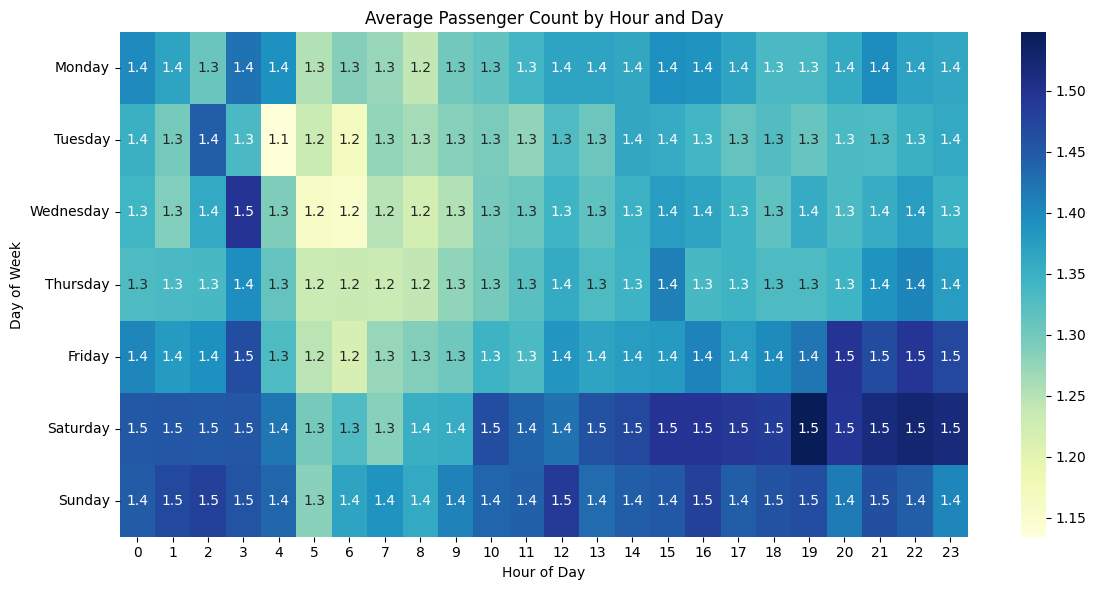

In [ ]:
# See how passenger count varies across hours and days
passenger_by_hour_day = df.groupby(['pickup_day', 'pickup_hour'])['passenger_count'].mean().reset_index()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

heatmap_data = passenger_by_hour_day.pivot(index='pickup_day', columns='pickup_hour', values='passenger_count')

heatmap_data = heatmap_data.reindex(day_order)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title('Average Passenger Count by Hour and Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()



**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

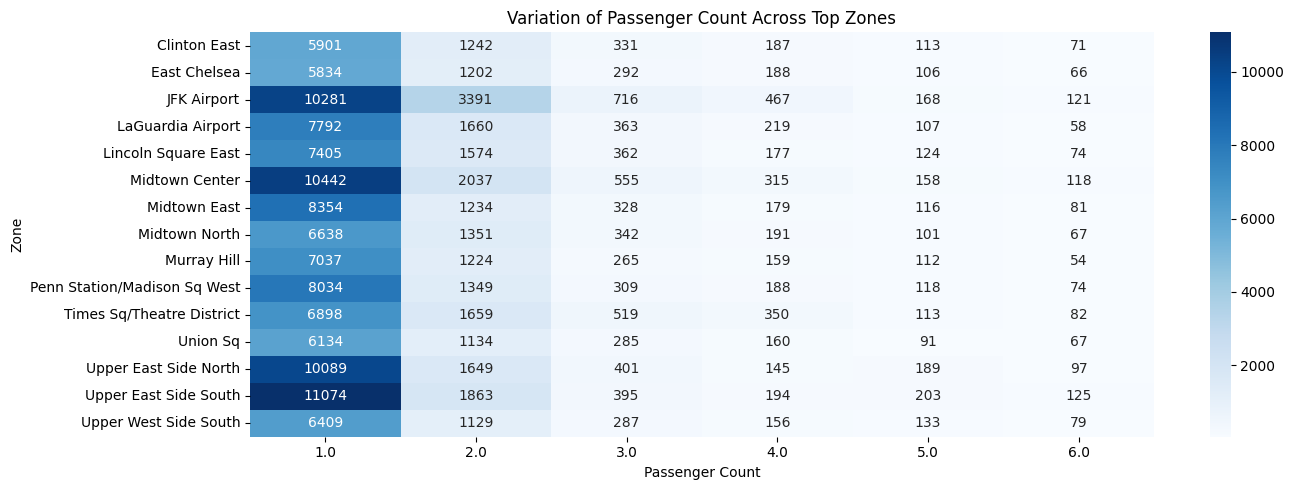

In [ ]:
# How does passenger count vary across zones

zone_passenger_variation = df.groupby(['PULocationID', 'passenger_count']).size().reset_index(name='count')


zone_passenger_variation = zone_passenger_variation.merge(zones_df[['LocationID', 'zone']], left_on='PULocationID', right_on='LocationID')

pivot_data = zone_passenger_variation.pivot_table(index='zone', columns='passenger_count', values='count', fill_value=0)

top_zones = df['PULocationID'].value_counts().head(15).index
pivot_data = pivot_data.loc[pivot_data.index.isin(zones_df[zones_df['LocationID'].isin(top_zones)]['zone'])]

plt.figure(figsize=(14, 5))
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='Blues')
plt.title('Variation of Passenger Count Across Top Zones')
plt.xlabel('Passenger Count')
plt.ylabel('Zone')
plt.tight_layout()
plt.show()

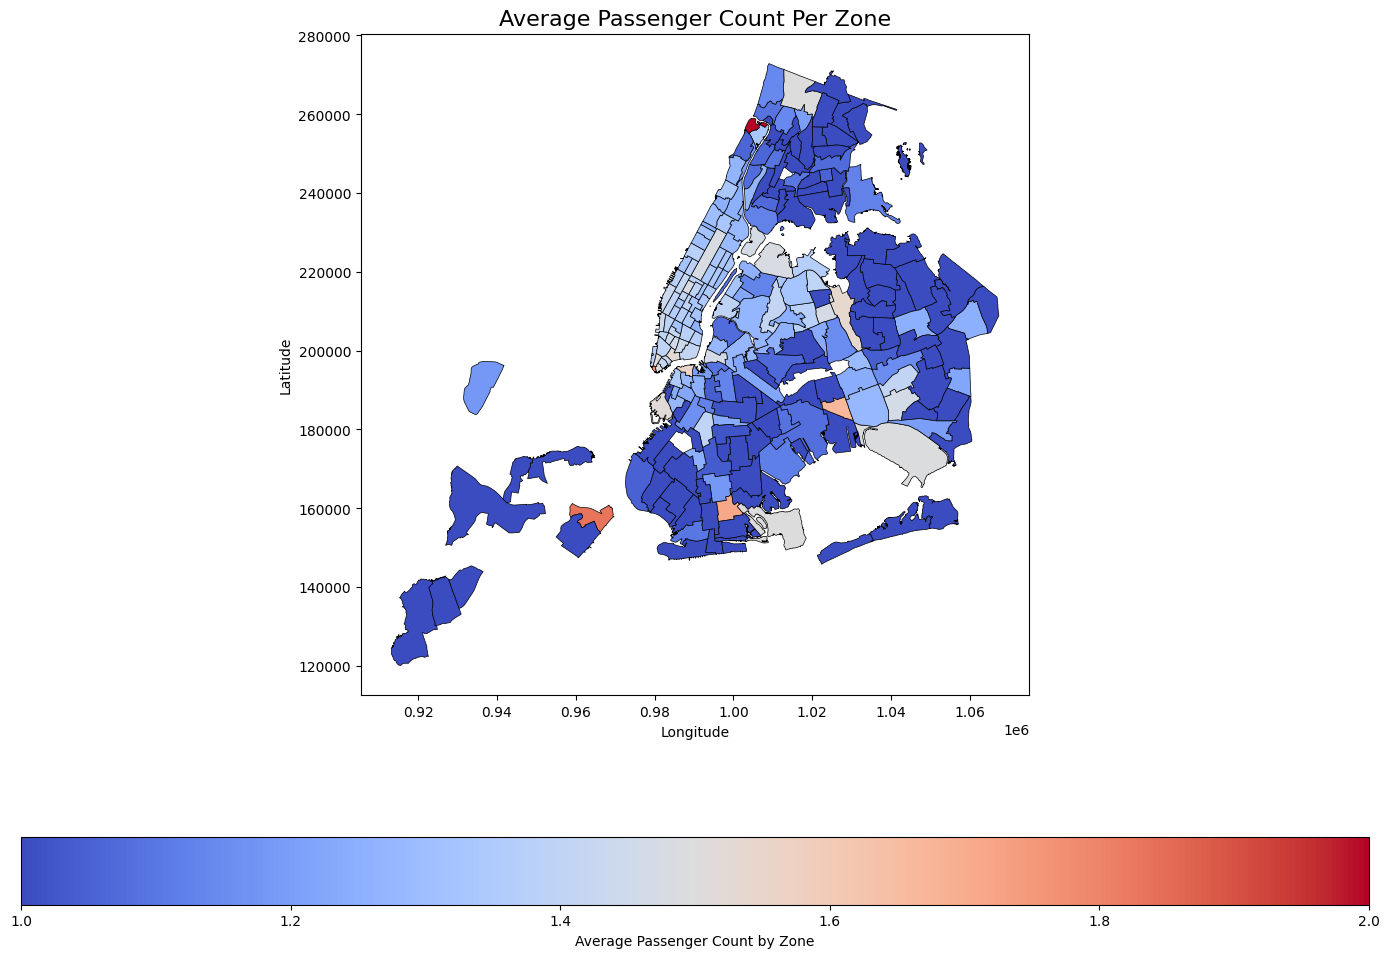

In [ ]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.

zone_trip_data = df.groupby('PULocationID')['passenger_count'].mean().reset_index()
zone_trip_data.rename(columns={'PULocationID': 'LocationID', 'passenger_count': 'avg_passenger_count'}, inplace=True)
zones_with_trips = zones_df.merge(zone_trip_data, on='LocationID', how='left')

zone_passenger_counts = df.groupby('PULocationID')['passenger_count'].mean().reset_index()

zone_passenger_counts.rename(columns={
    'PULocationID': 'LocationID',
    'passenger_count': 'avg_passenger_count'
}, inplace=True)


zones_with_trips = zones_df.merge(zone_passenger_counts, on='LocationID', how='left')

fig, ax = plt.subplots(figsize=(14, 10))

zones_with_trips.plot(column='avg_passenger_count', ax=ax, legend=True,
                     legend_kwds={'label': "Average Passenger Count by Zone",
                                  'orientation': 'horizontal'},
                     cmap='coolwarm', edgecolor='k', linewidth=0.5)


plt.title("Average Passenger Count Per Zone", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()

plt.show()

Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

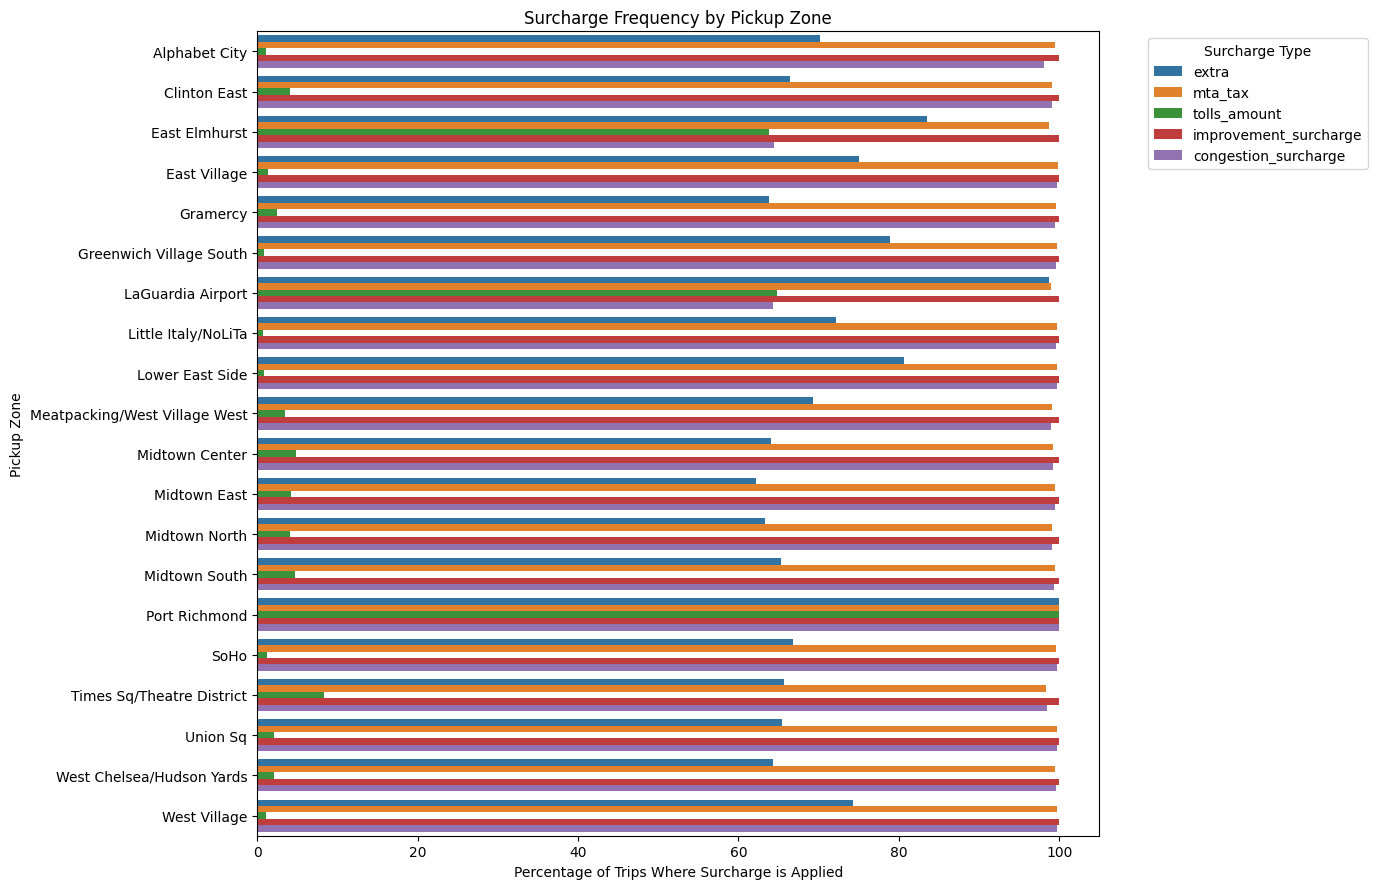

In [ ]:
# How often is each surcharge applied?

surcharge_cols = ['extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge']
surcharge_df = df[['PULocationID'] + surcharge_cols].copy()

# Convert all surcharge indicators to binary (1 if applied, 0 otherwise)
for col in surcharge_cols:
    surcharge_df[col] = (surcharge_df[col] > 0).astype(int)

# Group by pickup zone and calculate mean (i.e., % of trips where surcharge is applied)
surcharge_rates = surcharge_df.groupby('PULocationID')[surcharge_cols].mean() * 100
surcharge_rates = surcharge_rates.reset_index()

# Merge with zone names
surcharge_rates = surcharge_rates.merge(zones_df[['LocationID', 'zone']], left_on='PULocationID', right_on='LocationID', how='left')

# Melt for plotting
surcharge_long = surcharge_rates.melt(id_vars=['zone'], value_vars=surcharge_cols,
                                      var_name='Surcharge Type', value_name='Applied %')

# Filter top 20 zones with most frequent surcharges on average
surcharge_long_grouped = surcharge_long.groupby('zone')['Applied %'].mean().reset_index()
top_zones = surcharge_long_grouped.sort_values(by='Applied %', ascending=False).head(20)['zone'].tolist()
plot_data = surcharge_long[surcharge_long['zone'].isin(top_zones)]

# Plot
plt.figure(figsize=(14, 9))
sns.barplot(data=plot_data, x='Applied %', y='zone', hue='Surcharge Type', palette='tab10')
plt.title('Surcharge Frequency by Pickup Zone')
plt.xlabel('Percentage of Trips Where Surcharge is Applied')
plt.ylabel('Pickup Zone')
plt.legend(title='Surcharge Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies



*  We need to have high availability of cabs during 3PM to 7PM (Peak hours) during weekdays.
*   Avoid the slowest routes like 'Two Bridges/Seward Park' to 'Downtown Brooklyn/MetroTech' and from 'Upper East Side South' to 'Queensbridge/Ravenswood' during peak hours. Also try avoiding 'Sunnyside' and 'Randalls island' in the route.
*   Do not dispatch any cab in the following zones, where the pickup/dropoff ratio is very low - 'Pelham Park/Pelham Bay Park' and 'County Club'
*   Dispatch empty cabs to Airport zones as the pickup and drop ratio is good - JFK Airport and LaGuardia Airport
*   Around 12 PM to 7 PM we can dispatch cabs to the following zones as we could observe there is a good number of pickups and drops during those hours -
          1.   Midtown Center
          2.   Upper East Side North
          3.   Upper East Side South



*   During night (11PM to 5AM) dispatch cabs to the following zones where there is highest pickups and drops
          1.   East Village
          2.   West Village
          3.   Cliton East
          4.   JFK Airport
          5.   Lower East Side
          6.   Times Sq/Theater District


*   Do not dispatch cab in night to the following zones as there is no pickups and drop off noticed.
          1.   Arden Heights
          2.   Bloomfield/Emerson Hill
          3.   Broad Channel


*   We can encourage shared trips in airport zones.















**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.



*   Make sure the availablity of Cab is high during weekdays than weekends.
*   And more cabs should be dispatched during the evening peak hours (3 PM to 7 PM).
*   High demand months are May and October.
*   Dispatch more cabs during evenings in Saturday, as analysed the passeneger count is more during 2 PM to 11 PM.
*   We get more revenue during the Q4, this could be because of the holiday season. Deploy more cabs near tourist places and hotels.
*   The average fare per mile is more on Sundays, so we can deploy more cabs as even in the case of short distance trip we get more fare amount.
*   Dispatch more cabs in daytime than night time.
*   Deploy cabs to manage peak hours during busy days - Thursday and Wednesday.














**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.



*   For 0 to 2 mile the fare per mile is more in 'VeriFone Inc.' it can be reduced similar to the pricing of 'Creative Mobile Technologies, LLC'.
*   Moslty we have more trips booked for the passenger count 1, so we can encourage car pooling type booking so we can reduce the fuel usage and same time get more revenue.
*   Increase fare charge during peak hours, like during the evenings in weekdays.
*   Giving offers and discount for any booking above 50 miles, encouraging long trips. As the fare amount increases as the distance increases. So currently the frequency on long trips is less so it has to be worked on.
*   Increase fare amounts for Airports and late night bookings.
*   Increase fare amount when the drop location has very low pick up ratio.
*   Creating a membership plan and providing discount and points that can be redeemed as per the number of bookings done.
*   Less fare amount during less peak hours like 3 AM to 5 AM.
*   Increase fare amount for zones with high charges. For Example, Port Richmond has all kind of charges applied to almost all the trips.
*   Introduce waiting charge.









